#IBC Intelligent Building Configurator - Alpha

#Apartment-Level Floor Plan Dataset Derived From MSD

In this notebook, we look into the Modified Swiss Dwelling (MSD)  which is a dataset of apartment-level floor plans  that are information-rich and easy-to-work with. We go through this large dataset of floorplans and try to examine how these floorplans could be re-designed using a kit of parts
This notebook is a Work in Progress (WIP) and contains the following sections:

**(1) Floorplan Analysis.**
From the table (.csv) associated with the MSD floor plan dataset, we extract all distinct apartments that can be found in there but also extract spatial properties (i.e., we develop a function that filters all the building elements corresponding to a particular apartment ID).

**(2) Apartment-level graph extraction.**
Each apartment (i.e., list of building elements) is subsequently converted into a richly-attributed graph, where nodes represent rooms and edges their relations.
**Node attributes** include the room's geometry and function.
**Edge attributes** include the type of connectivity and the associated geometry (e.g., geometry of the door) if such a geometry exists in the first place.
**Graph-level** attributes include the floor ID, apartment ID, and the sets of walls and windows (as geometries) that 'built' the apartment.
We have developed some sophisticated plotting functions in which it is remarkably easy to include your own coloring scheme, and which type of elements you want to be visualized (e.g., whether you want to see back walls, windows, doors, or entrances).

**(3) Filtering.**
In here we remove apartments that are too small or too large ($5 \leq N \leq 12 $, $N$ is the number of rooms), that are not connected (i.e., there exist two, or more, subgraphs that do not share any edge between their corresponding sets of nodes).


**(4) Meta-data analysis.**
In this section, we provide some meta-data about the apartment-level floor plan dataset.
These meta-data regards mostly distributions, such as the distribution of the number of rooms (numeric).



## (0) Load and Explore the Dataset

This part explains how to extract the apartment-level graphs from the corresponding dataframe of MSD and, subsequently, how to nicely visualize the layouts and corresponding connectivity from these graphs.





We load the CSV as a `geopandas` dataframe:

In [1]:
#Uncomment to mount a drive from google drive
from google.colab import drive
from pathlib import Path
# Mounts drive
drive.mount('/content/drive')
#file on Gdrive
MSD_file_path = Path("/content/drive/My Drive/MSD_V2/mds_V2_5.372k.csv")# ! change this to your directory


Mounted at /content/drive


In [ ]:
import pandas as pd
import os
from geopandas import GeoDataFrame as gdf
from pathlib import Path


#TO DO MAKE IT RAN local file path
# Define local file path using pathlib
#MSD_file_path = Path(r"C:/Users/panz/Downloads/mds_V2_5.372k.csv")
current_path = os.getcwd()
# Check if the file exists
if MSD_file_path.exists():
    print(f"Current Directory:{current_path}")
    print(f"File found at: {MSD_file_path}")
    DF = pd.read_csv(MSD_file_path)

    # Summary stats
    print(f'Number of buildings in the dataset: {DF["building_id"].nunique()}')
    print(f'Number of floors: {DF["floor_id"].nunique()}')
    print(f'Number of apartments in the dataset: {DF["apartment_id"].nunique()}')


else:
    print("File not found! Check the path and try again.")

Current Directory:/content
File found at: /content/drive/My Drive/MSD_V2/mds_V2_5.372k.csv
Number of buildings in the dataset: 2550
Number of floors: 5372
Number of apartments in the dataset: 18269


To get an idea of the information within the dataframe, let's show the top (`.head`) of it.
Note that many of the columns from the *Swiss Dwellings* dataset ($\longrightarrow$ [Swiss Dwellings](https://zenodo.org/records/7788422)) are removed, to reduce clutter.

In [ ]:
DF.head(40)  # By default, head shows 5. Let's do a bit more, say 10.

,Unnamed: 0.1,Unnamed: 0,apartment_id,site_id,building_id,plan_id,floor_id,unit_id,area_id,unit_usage,entity_type,entity_subtype,geom,elevation,height,zoning,roomtype
0,0,0,3c3b1d6ca8b4b9092480b8c75f9eaa81,210,399,1054,1588,7300.0,619311.0,RESIDENTIAL,area,BATHROOM,POLYGON ((-2.7337844078265210 4.07980744083215...,0.0,2.6,Zone3,Bathroom
1,1,1,3c3b1d6ca8b4b9092480b8c75f9eaa81,210,399,1054,1588,7300.0,619303.0,RESIDENTIAL,area,LIVING_ROOM,POLYGON ((5.8278988701887320 7.816876723402971...,0.0,2.6,Zone2,Livingroom
2,2,2,3c3b1d6ca8b4b9092480b8c75f9eaa81,210,399,1054,1588,7300.0,619322.0,RESIDENTIAL,area,ROOM,POLYGON ((6.7557107205191187 2.413369594812586...,0.0,2.6,Zone1,Bedroom
3,3,3,3c3b1d6ca8b4b9092480b8c75f9eaa81,210,399,1054,1588,7300.0,619310.0,RESIDENTIAL,area,KITCHEN,POLYGON ((3.5821200013910017 5.140461688341117...,0.0,2.6,Zone2,Kitchen
4,4,4,3c3b1d6ca8b4b9092480b8c75f9eaa81,210,399,1054,1588,7300.0,619312.0,RESIDENTIAL,area,ROOM,POLYGON ((3.0141380455489282 4.182056855151666...,0.0,2.6,Zone1,Bedroom
5,5,5,3c3b1d6ca8b4b9092480b8c75f9eaa81,210,399,1054,1588,7300.0,619314.0,RESIDENTIAL,area,BALCONY,POLYGON ((6.6332818443542809 1.893154628642479...,0.0,2.6,Zone4,Balcony
6,6,6,3c3b1d6ca8b4b9092480b8c75f9eaa81,210,399,1054,1588,7300.0,619315.0,RESIDENTIAL,area,CORRIDOR,POLYGON ((-0.8407103586364295 2.49132970436546...,0.0,2.6,Zone2,Corridor
7,7,7,3c3b1d6ca8b4b9092480b8c75f9eaa81,210,399,1054,1588,7300.0,NaN,RESIDENTIAL,separator,WALL,POLYGON ((10.1119554317056775 4.97986505334461...,0.0,2.6,Structure,Structure
8,8,8,3c3b1d6ca8b4b9092480b8c75f9eaa81,210,399,1054,1588,7300.0,NaN,RESIDENTIAL,separator,WALL,POLYGON ((-1.1111620360693770 4.87501963298749...,0.0,2.6,Structure,Structure
9,9,9,3c3b1d6ca8b4b9092480b8c75f9eaa81,210,399,1054,1588,7300.0,NaN,RESIDENTIAL,separator,WALL,POLYGON ((3.9249330187591767 -1.31971700237801...,0.0,2.6,Structure,Structure


Each element in the dataframe is an architectural element, and has a corresponding geometry (`geom`), which is a represented by polygon.
Each element is located in:

- a particular site (accessed by the column `site_id`);
- a building (`building_id`);
- a floor (`floor_id)`; and
- an apartment (`apartment_id')`.

(We leave `plan_id`, `unit_id`, and `area_id` for what they are now. I.e.: we do not need them here.)

Before we extract the geometries, let's get an idea of the separator, opening, and room types:

In [ ]:
# List types of separators
print("The following types of separators between spaces exist in the dataset:")
print(list(DF[DF.entity_type == 'separator'].entity_subtype.unique()))

# List types of openings
print("The following types of openings exist in the dataset:")
print(list(DF[DF.entity_type == 'opening'].entity_subtype.unique()))

# List types of circulation
print("The following type possible represents circulation cores:")
print(list(DF[DF.roomtype == 'Stairs'].roomtype.unique()))
print(list(DF[DF.roomtype == 'Corridor'].roomtype.unique()))
print(list(DF[DF.roomtype == 'Elevator'].roomtype.unique()))

# Show room types
print("The following types of spaces exist in the dataset:")
print(list(DF.roomtype.unique()))

# Show Zoning
print("The following types of zoning exist in the dataset:")
print(list(DF.zoning.unique()))

The following types of separators between spaces exist in the dataset:
['WALL', 'COLUMN']
The following types of openings exist in the dataset:
['DOOR', 'WINDOW', 'ENTRANCE_DOOR']
The following type possible represents circulation cores:
['Stairs']
['Corridor']
[]
The following types of spaces exist in the dataset:
['Bathroom', 'Livingroom', 'Bedroom', 'Kitchen', 'Balcony', 'Corridor', 'Structure', 'Door', 'Window', 'Entrance Door', 'Dining', 'Stairs', 'Storeroom']
The following types of zoning exist in the dataset:
['Zone3', 'Zone2', 'Zone1', 'Zone4', 'Structure', 'Door', 'Window', 'Entrance Door']


Note that we will only need the `roomtype` column for all the information that we want as doors, entrance doors, and windows are already included as distinct categories already.


## (1) Floorplan Analysis

### Extracting geometries

Let's get the geometries associated with the walls and columns (1), doors (2), entrance doors (3), and windows (4).
We will do so for one floor (randomly sampled from the list of floor IDs in `floor_id`)

In [ ]:
#imports
from shapely import wkt
"""Function that extracts all geometries and associated categories from a
    particular floor and apartment ID. Outputs a list of geometries (1),
    a corresponding list of categories (2) and a list of zoning (3)"""

#GET GEOMETRIES BY ID
def get_geometries_from_id(df, building_id, floor_id, apartment_id=None, column='roomtype'):
    # Samples dataframe based on floor and, if asked for, apartment ID
    df_floor = df[df.floor_id == floor_id].reset_index(drop=True)
    if apartment_id is not None:
        df_floor = df_floor[df_floor.apartment_id == apartment_id].reset_index(drop=True)
    else:
        pass

    # Check if df_floor is empty before proceeding
    if df_floor.empty:
        print(f"Warning: No data found for floor_id={floor_id}, apartment_id={apartment_id}, column={column}")
        return [], [], []  # Return empty lists if no data is found

    df_floor.geom = df_floor.geom.apply(wkt.loads)

    # Get geometries and associated categories out
    geoms, cats, zonings = zip(*df_floor[["geom", column,"zoning"]].values)

    return geoms, cats, zonings

Select a building to Analyze and print out some basinc information about it

In [ ]:
#GET AN ID OF A BUIDLDING by providing a differen index number from 0-2550
#Has passed Test  1 ,30, 50 ,100,500
#100 two apartments


#Change this to select a different building
selectedbuildingNumber = 100
#FLOOR
selectedFloor = 1

# Gets list of building IDs and samples one (at 0)
building_ids = list(DF.building_id.dropna().unique())

#Get the building ID =
#ID of demo building 399

building_id = building_ids[selectedbuildingNumber]
print(DF.building_id[building_id ])

# Gets list of floor IDs for the specific building
floor_ids = list(DF[DF.building_id == building_id].floor_id.dropna().unique())

# Change the number to grab a different floor from the selected building
floor_id = floor_ids[selectedFloor]  # You can change this index to get a different floor

# Gets list of apartment IDs within the given floor of the selected building
apartment_ids = list(DF[(DF.building_id == building_id) & (DF.floor_id == floor_id)].apartment_id.dropna().unique())

# Gets geometries and associated categories for the selected building and floor
geoms, cats, zonings = get_geometries_from_id(DF, building_id, floor_id)

# Identifying spaces, walls, doors, etc., as before
spaces = [geom for geom, type in zip(geoms, cats) if type in ['Bathroom', 'Livingroom', 'Bedroom', 'Kitchen', 'Balcony', 'Corridor', 'Dining', 'Storeroom']]  # (1) spaces
walls = [geom for geom, type in zip(geoms, cats) if type == 'Structure']  # (1) Walls and columns
doors = [geom for geom, type in zip(geoms, cats) if type == 'Door']  # (2) Doors
entrances = [geom for geom, type in zip(geoms, cats) if type == 'Entrance Door']  # (3) Entrance doors
windows = [geom for geom, type in zip(geoms, cats) if type == 'Window']  # (4) Windows
cores = [geom for geom, type in zip(geoms, cats) if type == 'Stairs']  # (5) Circulation cores
shafts = [geom for geom, type in zip(geoms, cats) if type == 'Shaft']  # (6) Shafts

# Count distinct zones (excluding "Structure" if desired)
distinct_zones = set(z for z in zonings if z != 'Structure')

# Get geometries and categories for each apartment ID
apartments = []
for apartment_id in apartment_ids:
    geoms, cats, zonings = get_geometries_from_id(DF, building_id, floor_id, apartment_id)
    apartments.append([geoms, cats, zonings])

#do some prints for sanity Check
print(f"The ID of the selected building is:\t\t\t\t{building_id} \n"
      f"The number of floors in this building is:\t\t\t{len(floor_ids)} \n"
      f"The selected floor {selectedFloor} and its ID is:\t\t\t\t{floor_id} \n"
      f"Number of apartments on selected floor:\t\t\t\t{len(apartment_ids)}\n"
      f"Number of spaces on the floor:\t\t\t\t\t{len(spaces)}\n"
      f"Number of zones on the floor:\t\t\t\t\t{len(distinct_zones)}\n"
      f"Number of ciculation spaces (stairs, elevators etc):\t\t{len(cores)}\n"
      f"Number of Ventilation Shafts:\t\t\t\t\t{len(shafts)}\n"
      f"Number of structural elements:\t\t\t\t\t{len(walls)}\n"
      f"Number of doors:\t\t\t\t\t\t{len(doors)}\n"
      f"Number of entrances:\t\t\t\t\t\t{len(entrances)}\n"
      f"Number of windows:\t\t\t\t\t\t{len(windows)}\n")


2922
The ID of the selected building is:				1349 
The number of floors in this building is:			4 
The selected floor 1 and its ID is:				5865 
Number of apartments on selected floor:				2
Number of spaces on the floor:					16
Number of zones on the floor:					7
Number of ciculation spaces (stairs, elevators etc):		1
Number of Ventilation Shafts:					0
Number of structural elements:					43
Number of doors:						14
Number of entrances:						4
Number of windows:						12



###Utility functions

In [ ]:
#UTILITY FUNCTIONS
# A set of functions that help into deawing
# Suggested colors for each geometry type

#get the different room names and assign a different color to it
room_names = ['Bedroom', 'Livingroom', 'Kitchen', 'Dining', 'Corridor', 'Stairs', 'Storeroom', 'Bathroom', 'Balcony']
room_colors = [           '#D8DDCE',   # bedroom
                         '#F7F3D5',  # living room
                         '#EADED9',   # kitchen
                         '#EEDA9F',   # dining
                         'violet',   # corridor
                         '#72246c',  # stairs
                         '#E9E8E8',  # storeroom
                         '#4084B2',   # bathroom
                         'darkgrey']  # balcony


colors = [
    '#000000',  # 0 - Walls (Structure)
    '#FF0000',  # 1 - Doors
    "goldenrod",  # 2 - Entrance Doors
    "deepskyblue",  # 3 - Windows
    "Lightgrey",  # 4 - Internal spaces (Bathroom, Bedroom, etc.)
    "darkgrey",  # 5 - External spaces (e.g., Balcony)
    "violet",  # 6 - Corridors (all)
    "purple",  # 7 - Core corridors (filtered)
    "yellow",  # 8 - Stairs (Cores)
]

#  Naming for legend
sep_names = [
    "Walls and columns", #0
    "Doors", #1
    "Entrances", #2
    "Windows", #3
    "Floor", #4
    "Balcony", #5
    "Apartment Corridor",#6
    "Circulation Corridor", #7
    "Stairs",#8
    ]


#plot polygon with color
def plot_polygon(ax, poly, label=None, **kwargs):
    """Plots a polygon by filling it up. Edges of shapes are avoided to show exactly the area that
    the elements occupy."""
    x, y = poly.exterior.xy
    ax.fill(x, y, label=label, **kwargs)
    return

#Remove duplication
def remove_duplicate_geometries(geoms):
    unique = []
    for g in geoms:
        if not any(g.equals(u) for u in unique):
            unique.append(g)
    return unique



#DRAW ROOMS
def draw_rooms(ax, geoms, cats, zonings, room_colors, room_names):
    """Draws the rooms of the floor plan layout."""
    # Simultaneously extract geometries and categories
    # And directly plot them int the correct color
    for geom, cat in zip(geoms, cats):
        if cat in room_names:
            color = room_colors[room_names.index(cat)]
            plot_polygon(ax, geom, facecolor=color)

            # Get representative point for labeling
            try:
                label_point = geom.representative_point()
                ax.text(label_point.x, label_point.y, cat, fontsize=8, ha='center', va='center', color='black')
            except:
                pass  # In case of geometry issues


### Plot floorplan and identify circulation cores
Let's try to identify different elements within a selected floorplan of a Building such as the a) the structural relemts b) stairs, the circulation cores c)apartments d) room types . Let's plot the elements seperately figures.
(NEED TO BE FURTHER TESTED).


Saving plots to: /content/drive/My Drive/MSD_V2/ouput
Plot saved as /content/drive/My Drive/MSD_V2/ouput/floorplan_1349_5865.png


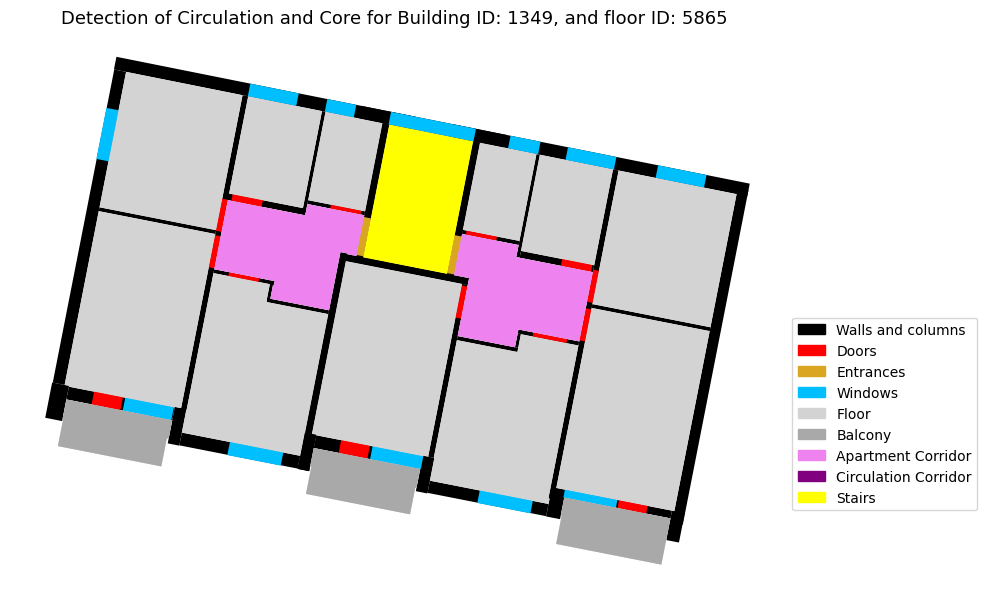

In [ ]:
#REVISED version for identifying ciruclation corridors and cores -has been tested but needs further testing
#plot a floorplan
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

#set the Font
plt.rcParams['font.family'] = 'DejaVu Sans'

geoms, cats, zonings = get_geometries_from_id(DF, building_id, floor_id)

# call function for drawing elements
def draw_walls_and_openings(ax, geoms, cats, zonings, apartment_ids, colors, debug=False,label_rooms=False):
    """Draws elements of the floor and identifies circulation corridors based on entrance vs. door contact."""

    # Classify geometry by category
    walls      = [g for g, c in zip(geoms, cats) if c == 'Structure']
    doors = remove_duplicate_geometries([g for g, c in zip(geoms, cats) if c == 'Door'])
    entrances = remove_duplicate_geometries([g for g, c in zip(geoms, cats) if c == 'Entrance Door'])
    windows    = [g for g, c in zip(geoms, cats) if c == 'Window']
    intSpaces  = [g for g, c in zip(geoms, cats) if c in ['Bathroom', 'Livingroom', 'Bedroom', 'Kitchen', 'Balcony', 'Corridor', 'Dining', 'Storeroom']]
    extSpaces  = [g for g, c in zip(geoms, cats) if c == 'Balcony']
    cores      = [g for g, c in zip(geoms, cats) if c == 'Stairs']
    corridors  = [g for g, c in zip(geoms, cats) if c == 'Corridor']
    corridor_zones = [zone for geom, cat, zone in zip(geoms, cats, zonings) if cat == 'Corridor']

    # Identify core corridors
    buffer_size = 0.001  # You may tune this if needed
    core_corridors = []

    for i, (corridor, zone) in enumerate(zip(corridors, corridor_zones)):
        # add some buffer to make sure shapes interset
        buffered_corridor = corridor.buffer(buffer_size)
        entrance_count = 0
        door_count = 0

        # Count entrances intersecting corridor
        for entrance in entrances:
            if corridor.touches(entrance) or corridor.intersects(entrance):
                entrance_count += 1

       # Count doors intersecting corridor
        for door in doors:
            if buffered_corridor.intersects(door) or buffered_corridor.touches(door):
                door_count += 1
          #check if corridors intersect  with doors and entrances
        # Logic to identify circulation corridors
        core_corridor_condition1 = (zone == "Zone3") and (entrance_count > door_count)
        core_corridor_condition2 = (zone == "Zone2") and (entrance_count > door_count)
        core_corridor_condition3 = (door_count != 0) or (door_count != 1)

        # add logic if stairs intersects with corridor or touches
        if core_corridor_condition1 :
          core_corridors.append(corridor)
          #print (f"Found circulation corridor [Corridor {i}] in the first case")
        elif core_corridor_condition2 and core_corridor_condition3 :
          core_corridors.append(corridor)
          #print (f"Found circulation corridor [Corridor {i}]   in the second case")
        elif core_corridor_condition2 :
          core_corridors.append(corridor)
          #print (f"Found circulation corridor [Corridor {i}]   in the third case")
        #print(f"[Corridor {i}] Entrances: {entrance_count}, Doors: {door_count},Zone: {zone}")

    # Add room names as labels
    if label_rooms:
        room_types = ['Bathroom', 'Livingroom', 'Bedroom', 'Kitchen', 'Dining', 'Corridor', 'Storeroom']  # customize as needed
        for geom, cat in zip(geoms, cats):
            if not geom.is_empty and hasattr(geom, 'centroid'):
                cx, cy = geom.centroid.coords[0]
                ax.text(cx, cy, cat, ha='center', va='center', fontsize=6, color='black')


    #debugging to make sure we are identifying correclty the spaces
    if (debug == True):
      #print (corridor_zones)
      print(f"\nTotal corridors: {len(corridors)}")
      print(f"Core corridors:  {len(core_corridors)}\n")
      print(f"Stairs&Elevators:  {len(cores)}\n")
      print(f"Entrances:  {len(entrances)}\n")
      print(f"Doors:  {len(doors)}\n")
      #print(entrances)

    # Plot
    _ = [plot_polygon(ax, g, facecolor=colors[0]) for g in walls]
    _ = [plot_polygon(ax, g, facecolor=colors[1]) for g in doors]
    _ = [plot_polygon(ax, g, facecolor=colors[2]) for g in entrances]
    _ = [plot_polygon(ax, g, facecolor=colors[3]) for g in windows]
    _ = [plot_polygon(ax, g, facecolor=colors[4]) for g in intSpaces]
    _ = [plot_polygon(ax, g, facecolor=colors[5]) for g in extSpaces]
    _ = [plot_polygon(ax, g, facecolor=colors[8]) for g in cores]
    _ = [plot_polygon(ax, g, facecolor=colors[6]) for g in corridors]
    _ = [plot_polygon(ax, g, facecolor=colors[7]) for g in core_corridors]


    return core_corridors, corridors, cores, doors


# Set figure and specs
fs = 10
fig, ax = plt.subplots(1, 1, figsize=(fs, fs))
ax.set_aspect('equal')
ax.axis('off')
ax.set_title(f"Detection of Circulation and Core for Building ID: {building_id}, and floor ID: {floor_id} ", fontsize=fs + 3)

# Plot geometries
#draw_walls_and_openings(ax, geoms, cats, zonings, sep_colors)
core_corridors, _, _, _ = draw_walls_and_openings(ax, geoms, cats, zonings, apartment_ids, colors)


# Create legend (left middle outside)
patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, sep_names)]
_ = plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1, 0.5), fontsize=fs)


# Save the figure in Drive
# Directory to save output
# (NEED TO CHANGE THIS TO LOCAL)
output_dir = r"/content/drive/My Drive/MSD_V2/ouput/"
os.makedirs(output_dir, exist_ok=True)  # Create it if it doesn't exist
output_filename = os.path.join(output_dir, f"floorplan_{building_id}_{floor_id}.png")

#save the figure
plt.savefig(output_filename, bbox_inches='tight', dpi=300)

print(f"Saving plots to: {os.path.abspath(output_dir)}")
print(f"Plot saved as {output_filename}")


### PLOT JUST THE STRUCTURE
That looks good.Let's do the same for only the structure


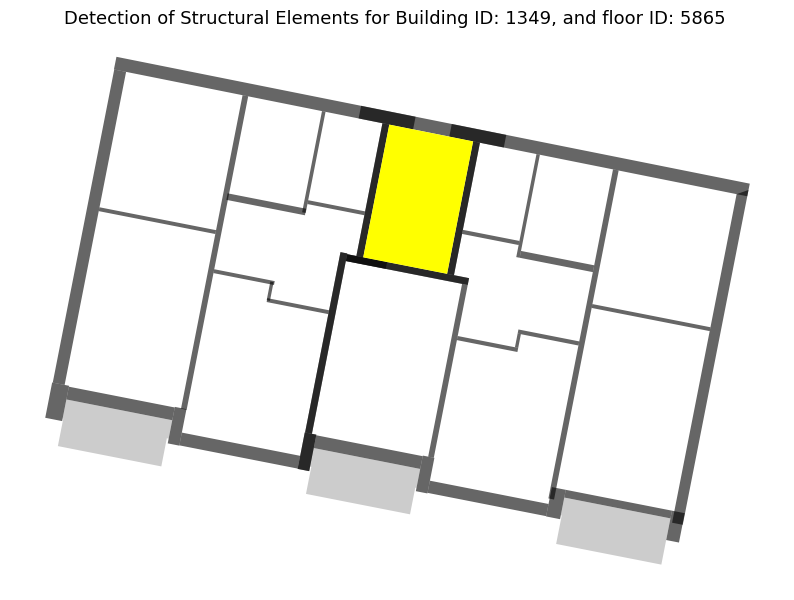

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from shapely.ops import unary_union

# Get tightest boundary of floor plan
# First: load all geometries that are walls or columns
# Second: Unite all these geometries using the union of them
# Third: Find the polygon within the union that is largest in terms of area (using np.argsort)
# and choose the largest (which is by default put on the end of the sort)
#structure = unary_union([geom for geom, cat in zip(geoms, cats) if cat == 'Structure'])
#boundary = structure.geoms[np.argsort([geom.area for geom in structure.geoms])[-1]]


geoms, cats, zonings = get_geometries_from_id(DF, building_id, floor_id)

walls      = [g for g, c in zip(geoms, cats) if c == 'Structure']
intSpaces  = [g for g, c in zip(geoms, cats) if c in ['Bathroom', 'Livingroom', 'Bedroom', 'Kitchen', 'Balcony', 'Corridor', 'Dining', 'Storeroom']]
extSpaces  = [g for g, c in zip(geoms, cats) if c == 'Balcony']
cores      = [g for g, c in zip(geoms, cats) if c == 'Stairs']
corridors  = [g for g, c in zip(geoms, cats) if c == 'Corridor']
corridor_zones = [zone for geom, cat, zone in zip(geoms, cats, zonings) if cat == 'Corridor']


slab = unary_union([geom for geom, cat in zip(geoms, cats) if cat == 'Structure' or cat == 'Balcony'])
slabBoundary = slab.geoms[np.argsort([geom.area for geom in slab.geoms])[-1]]

# Check whether the boundary / polygon makes sense
# (When a shapely Polygon object is called, the shape is directly visualized in the output.)

# Set Figure Specs
fs = 10
fig, ax = plt.subplots(1, 1, figsize=(fs, fs))
ax.set_title(f"Detection of Structural Elements for Building ID: {building_id}, and floor ID: {floor_id} ", fontsize=fs + 3)
ax.set_aspect('equal')
ax.axis('off')
_ = [plot_polygon(ax, g, facecolor=colors[0],alpha=.6) for g in walls]
_ = [plot_polygon(ax, g, facecolor=colors[0],alpha=.2) for g in extSpaces]
_ = [plot_polygon(ax, g, facecolor=colors[8]) for g in cores]
#_ = [plot_polygon(ax, g, facecolor=colors[7]) for g in core_corridors]
# Plot structure of the whole building
#plot_polygon(ax, slabBoundary, facecolor="black", alpha=.2)
#slab

Now that we have seen the structural elements. and we identified some building elements we will plot the space of each aparmtnet individually.
We draw them in different subplots.
And using `unary_union` from `shapely` we construct the boundary of the overall floor plan and plot it underneath the apartments in gray.

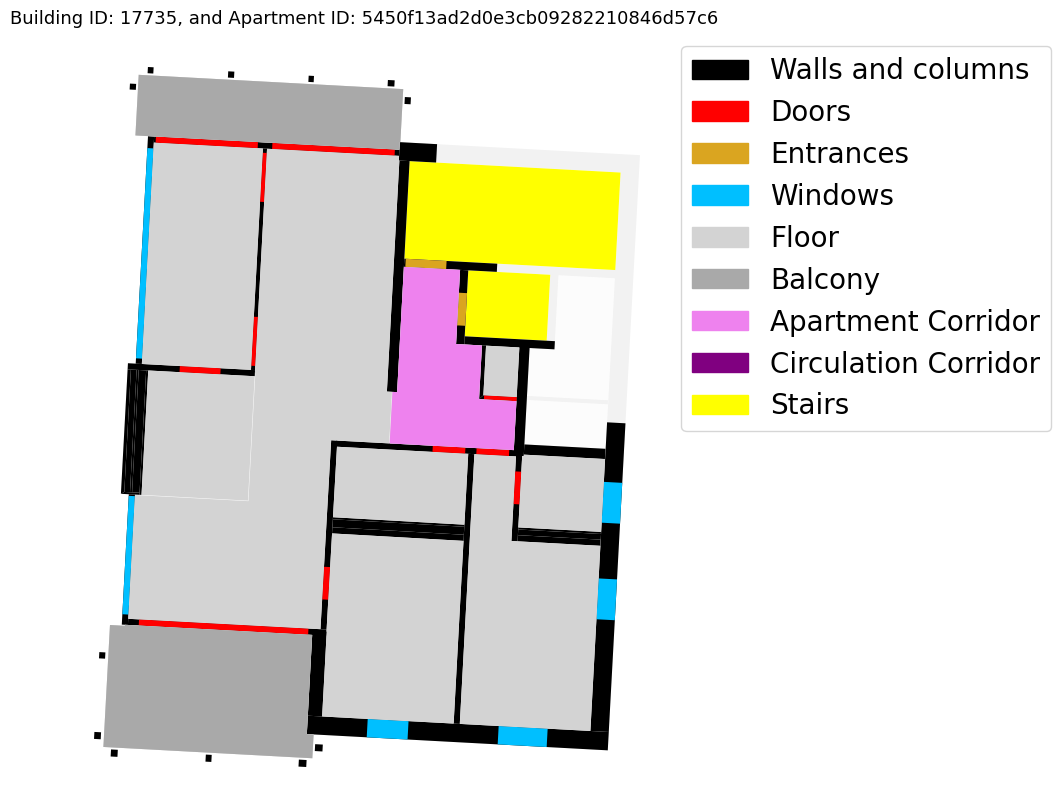

In [ ]:
# Set figure and specs

fs = 10
nc = len(apartments)  # Number of columns
fig, axs = plt.subplots(1, nc, figsize=(fs*nc, fs))
axs = axs.flatten() if nc > 1 else [axs]


# Loop through apartments
for ax, (geoms, cats,zonings) in zip(axs, apartments):
    # Set axis
    ax.set_aspect('equal')
    ax.axis('off')


    ax.set_title(f"Building ID: {building_id},  floor ID: {floor_id}, and Apartment ID: {apartment_id} ", fontsize=fs + 3)
    # Plot structure of the whole building
    _ = [plot_polygon(ax, g, facecolor=colors[0],alpha=.05) for g in walls]
    _ = [plot_polygon(ax, g, facecolor=colors[4],alpha=.05) for g in extSpaces]
    _ = [plot_polygon(ax, g, facecolor=colors[4],alpha=.05) for g in intSpaces]
    _ = [plot_polygon(ax, g, facecolor=colors[8]) for g in cores]
    #plot_polygon(ax, slabBoundary, facecolor="gray", alpha=0.2)

    # Plot geometries
    draw_walls_and_openings(ax, geoms, cats, zonings, apartment_ids,colors)

# Create legend (left middle outside)
patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, sep_names)]
_ = plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1, 1), fontsize=fs*2)

We can clearly see that the different apartments in this floorplan. Next we will add some color in the individual spaces!

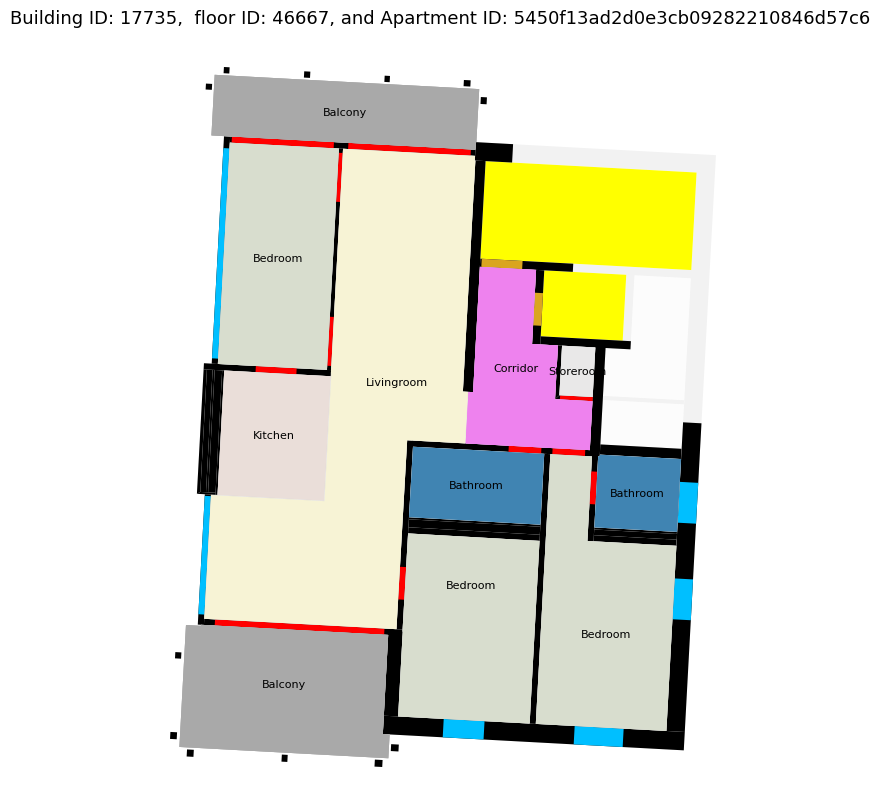

In [ ]:
#get the different room names and assign a different color to it
room_names = ['Bedroom', 'Livingroom', 'Kitchen', 'Dining', 'Corridor', 'Stairs', 'Storeroom', 'Bathroom', 'Balcony']
room_colors = [           '#D8DDCE',   # bedroom
                         '#F7F3D5',  # living room
                         '#EADED9',   # kitchen
                         '#EEDA9F',   # dining
                         'violet',   # corridor
                         '#72246c',  # stairs
                         '#E9E8E8',  # storeroom
                         '#4084B2',   # bathroom
                         'darkgrey']  # balcony

def draw_rooms(ax, geoms, cats, zonings, room_colors, room_names):
    """Draws the rooms of the floor plan layout."""
    # Simultaneously extract geometries and categories
    # And directly plot them int the correct color
    for geom, cat in zip(geoms, cats):
        if cat in room_names:
            color = room_colors[room_names.index(cat)]
            plot_polygon(ax, geom, facecolor=color)

            # Get representative point for labeling
            try:
                label_point = geom.representative_point()
                ax.text(label_point.x, label_point.y, cat, fontsize=8, ha='center', va='center', color='black')
            except:
                pass  # In case of geometry issues

# Set figure and specs
fs = 10
nc = len(apartments)  # Number of columns
fig, axs = plt.subplots(1, nc, figsize=(fs*nc, fs))
axs = axs.flatten() if nc > 1 else [axs]

#Colors and naming for legend
legend_colors = room_colors
names = room_names + sep_names
# Loop through apartments
for ax, (geoms, cats,zonings) in zip(axs, apartments):

    # Set axis
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(f"Building ID: {building_id},  floor ID: {floor_id}, and Apartment ID: {apartment_id} ", fontsize=fs + 3)

    # Plot  the whole building footprint with a bit of opcaity
    _ = [plot_polygon(ax, g, facecolor=colors[0],alpha=.05) for g in walls]
    _ = [plot_polygon(ax, g, facecolor=colors[4],alpha=.05) for g in extSpaces]
    _ = [plot_polygon(ax, g, facecolor=colors[4],alpha=.05) for g in intSpaces]
    _ = [plot_polygon(ax, g, facecolor=colors[8]) for g in cores]
    # Plot geometries
    draw_walls_and_openings(ax, geoms, cats, zonings, apartment_ids,colors)
    draw_rooms(ax, geoms, cats, zonings, room_colors, room_names)

# Create legend (left middle outside)
#patches = [mpatches.Patch(color=color, label=label) for color, label in zip(legend_colors, names)]
#_ = plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1, 1), fontsize=fs*2)

###PLOT THE APARTMENT ZONES
Now let's plot the same floorplan showing/color coded based on the zoning feature
TO DO COLOR BY APARTMENT

In [ ]:
from shapely.geometry import Polygon
import plotly.graph_objects as go
import random
geoms, cats, zonings = get_geometries_from_id(DF, building_id, floor_id)
def plot_interactive_floorplan(geoms, cats, zonings, **kwargs):
    """Plot geometries interactively with Plotly and show zone info on hover."""
    # Color map for zones
    zone_colors = {
        "Zone1": "lightblue",
        "Zone2": "lightgreen",
        "Zone3": "lightcoral",
        "Zone4": "Lightgrey",
        "Structure": "black"
    }
    # Create lists to store plotly data for each geometry type
    plot_data = []

    # Collect x and y values for axis limits
    all_x = []
    all_y = []

    for geom, cat, zone in zip(geoms, cats, zonings):
        # Get coordinates of the geometry's boundary (exterior)
        if isinstance(geom, Polygon):  # Handle polygons
            x, y = geom.exterior.xy
            # Convert the coordinates to lists if they are not already
            x = list(x)
            y = list(y)
            color = zone_colors.get(zone, "grey")  # Default to grey if no match

            # Create a trace for each geometry type
            trace = go.Scatter(
                x=x,
                y=y,
                mode='lines',
                fill='toself',
                fillcolor=color,
                name=f"{cat} ({zone})",  # Hover info will show category and zone
                line=dict(color=color, width=2),
                hoverinfo='text',
                text=f"{cat} - {zone}"  # Hover text
            )
            plot_data.append(trace)

            # Add coordinates to overall lists for axis limits
            all_x.extend(x)
            all_y.extend(y)

    # Create the figure
    fig = go.Figure(data=plot_data)

    # Update layout with titles, axis settings, and hover options
    fig.update_layout(
        # Set axis
        title="Floor Plan Showing Zoning in the apartment",
        showlegend=True,
        hovermode='closest',  # Ensures hover info is shown for closest point
        xaxis=dict(
            showgrid=False,
            zeroline=False,
            range=[min(all_x), max(all_x)],  # Set axis range based on coordinates
            showticklabels=False,  # Remove axis numbers/labels

        ),
        yaxis=dict(
            showgrid=False,
            zeroline=False,
            range=[min(all_y), max(all_y)],  # Set axis range based on coordinates
            showticklabels=False,  # Remove axis numbers/labels

        ),
        plot_bgcolor='white',  # Optional: Set a white background
        autosize=True,
    )

    # Show the plot
    fig.show()

plot_interactive_floorplan(geoms, cats, zonings)

### Plot multiple floorplans




In [ ]:
#BATCH export
#FILTER specific FLOORPLANS AND PLOT MULTIPLE floorplans and save an image for each
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import math
from pathlib import Path
import pandas as pd

# === Set Output path ===
output_dir = r"/content/drive/My Drive/MSD_V2/output_filteredPlans/"
os.makedirs(output_dir, exist_ok=True)

#FILTERING CRITERIA
noOfApartmentsOnFloor = 6
maxNumberOfFloors = 4

# Group by building and floor to count apartments
grouped = DF.dropna(subset=["building_id", "floor_id", "apartment_id"]).groupby(['building_id', 'floor_id'])
apartment_counts = grouped['apartment_id'].nunique().reset_index(name='apartment_count')

#Step 1
# Filter floors
valid_floors = apartment_counts[apartment_counts['apartment_count'] <= noOfApartmentsOnFloor]
building_floor_pairs = []


for building_id in building_ids:
    floor_ids = DF[DF.building_id == building_id].floor_id.dropna().unique()
    if len(floor_ids) > 0 and len(floor_ids)< maxNumberOfFloors:
        first_floor = floor_ids[0]  # take the first available floor
        building_floor_pairs.append((building_id, first_floor))
    else:
        print(f"No floor found for building {building_id}")

# Step 3: Count number of valid floors per building
building_floor_counts = valid_floors.groupby('building_id')['floor_id'].nunique().reset_index(name='valid_floor_count')

# Step 4: Filter buildings with exactly 2 or 3 valid floors
filtered_buildings = building_floor_counts[building_floor_counts['valid_floor_count'].between(2, 3)]

# Final list of building IDs
building_ids = filtered_buildings['building_id'].tolist()


#LOOP THROUGH ALL BUILDINGS
for building_id in building_ids:
    floor_ids = DF[DF.building_id == building_id].floor_id.dropna().unique()
    if len(floor_ids) > 0:
        first_floor = floor_ids[0]  # take the first available floor
        building_floor_pairs.append((building_id, first_floor))
    else:
        print(f"No floor found for building {building_id}")

# === Plot Grid Setup ===
N = len(building_floor_pairs)
cols = 4
rows = math.ceil(N / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 6))
axes = axes.flatten()


# Legend setup
patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, sep_names)]


# Loop and plot each separately
for building_id, floor_id in building_floor_pairs:
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(f"Building {building_id}, Floor {floor_id}", fontsize=12)

    apartment_ids = list(DF[(DF.building_id == building_id) & (DF.floor_id == floor_id)].apartment_id.dropna().unique())
    geoms, cats, zonings = get_geometries_from_id(DF, building_id, floor_id)

    draw_walls_and_openings(ax, geoms, cats, zonings, apartment_ids, colors)
    draw_rooms(ax, geoms, cats, zonings, room_colors, room_names)
    # Add legend (optional – makes images larger)
    ax.legend(handles=patches, loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=8)

    # Save
    output_filename = os.path.join(output_dir, f"building_{building_id}_floor_{floor_id}.png")
    plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    plt.close()
    print(f"Saved: {output_filename}")




In [ ]:
# this cell calls ALL available buildings AND SAVES AN IMAGE OF EACH FLOORPLAN
#takes long time!!!!
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Set font globally
plt.rcParams['font.family'] = 'DejaVu Sans'


# --- Cell 5: Loop through buildings and floors ---
output_dir = r"/content/drive/My Drive/MSD_V2/outputAllPlans/"


building_dir = os.path.join(output_dir, f"building_{building_id}")
os.makedirs(building_dir, exist_ok=True)


# ← your list
#all_Available_building_ids = DF['building_id'].unique()
all_Available_building_ids = [1, 2, 4,5,10,50,100, 200]
floor_ids = [0, 1]  # ← your list

floor_ids_by_building = {
    b_id: DF[DF['building_id'] == b_id]['floor_id'].unique()
    for b_id in all_Available_building_ids
}

for b_id, floors in floor_ids_by_building.items():
    for f_id in floors:
        draw_walls_and_openings(ax, geoms, cats, zonings, apartment_ids, colors)
        draw_rooms(ax, geoms, cats, zonings, room_colors, room_names)

output_filename = os.path.join(output_dir, f"building_{building_id}_floor_{floor_id}.png")
plt.savefig(output_filename, bbox_inches='tight', dpi=300)
#plt.close()
print(f"Saved: {output_filename}")

Saved: /content/drive/My Drive/MSD_V2/outputAllPlans/building_17735_floor_46667.png


<Figure size 640x480 with 0 Axes>

### RUN SIMILARITY ANALYSIS ve2
on buildings that meet certain criteria   (i.e. number of floors, or apartments)


Now let's try to identify room combinations that could be potential candidates for adding a 3d module
-Handles the setup and figure layout,
-Draws apartments and rooms,
-Overlays the custom polygon around selected room types (Corridor, Bathroom, Kitchen),
-Adds a reference polygon for shape comparison,
-Computes similarity metrics (IoU, area similarity, Hausdorff),
-Displays metrics on the plots.
TO DO HERE
Improve the metric
Save the cobination of the rooms see if can segment the areas

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from shapely.geometry import box
from shapely.affinity import translate, rotate
from shapely.ops import unary_union

def compute_similarity_scores_for_building(DF, building_id, floor_id,
                                           moduleWidth=3.20, moduleLength=6.55,
                                           output_csv=None, output_images_dir=None):
    """
    Computes similarity scores for apartments on a given floor in a building,
    based on fitting a reference 3D construction module.

    Parameters:
        DF : DataFrame containing geometry, apartment, floor, building info
        building_id : ID of the building
        floor_id : ID of the floor
        moduleWidth : width of reference 3D module
        moduleLength : length of reference 3D module
        output_csv : path to save CSV results (optional)
        output_images_dir : path to save apartment plots (optional)

    Returns:
        score_df : DataFrame of apartment similarity scores
    """

    # Get geometries from your helper (assumes it's already defined)
    geoms, cats, zonings = get_geometries_from_id(DF, building_id, floor_id)
    floor_df = DF[(DF.building_id == building_id) & (DF.floor_id == floor_id)]
    apartment_ids = list(floor_df.apartment_id.dropna().unique())
    # Classify geometry by category
    walls      = [g for g, c in zip(geoms, cats) if c == 'Structure']
    doors = remove_duplicate_geometries([g for g, c in zip(geoms, cats) if c == 'Door'])
    entrances = remove_duplicate_geometries([g for g, c in zip(geoms, cats) if c == 'Entrance Door'])
    windows    = [g for g, c in zip(geoms, cats) if c == 'Window']
    intSpaces  = [g for g, c in zip(geoms, cats) if c in ['Bathroom', 'Livingroom', 'Bedroom', 'Kitchen', 'Balcony', 'Corridor', 'Dining', 'Storeroom']]
    extSpaces  = [g for g, c in zip(geoms, cats) if c == 'Balcony']
    cores      = [g for g, c in zip(geoms, cats) if c == 'Stairs']
    corridors  = [g for g, c in zip(geoms, cats) if c == 'Corridor']
    corridor_zones = [zone for geom, cat, zone in zip(geoms, cats, zonings) if cat == 'Corridor']

    apartments = []

    for apartment_id in apartment_ids:
        apt_geoms = [g for g, a_id in zip(geoms, floor_df.apartment_id) if a_id == apartment_id]
        apt_cats = [c for c, a_id in zip(cats, floor_df.apartment_id) if a_id == apartment_id]
        apt_zones = [z for z, a_id in zip(zonings, floor_df.apartment_id) if a_id == apartment_id]
        apartments.append((apt_geoms, apt_cats, apt_zones))

    # Plotting setup
    fs = 6
    nc = len(apartments)
    fig, axs = plt.subplots(1, nc, figsize=(fs * nc, fs))
    axs = axs.flatten() if nc > 1 else [axs]

    per_apartment_scores = {}

    for ax, (apt_geoms, apt_cats, apt_zones), apartment_id in zip(axs, apartments, apartment_ids):
        ax.set_aspect('equal')
        ax.axis('off')

        # Light context
        _ = [plot_polygon(ax, g, facecolor='gray', alpha=0.05) for g in walls]
        _ = [plot_polygon(ax, g, facecolor='lightblue', alpha=0.05) for g in extSpaces + intSpaces]
        _ = [plot_polygon(ax, g, facecolor='orange') for g in cores]

        draw_walls_and_openings(ax, apt_geoms, apt_cats, apt_zones, apartment_ids, colors)
        draw_rooms(ax, apt_geoms, apt_cats, apt_zones, room_colors, room_names)

        target_geoms = [g for g, c in zip(apt_geoms, apt_cats) if c in ['Corridor', 'Bathroom', 'Kitchen']]
        if not target_geoms:
            continue

        merged_geom = unary_union(target_geoms)
        overlay_poly = merged_geom.convex_hull
        plot_polygon(ax, overlay_poly, facecolor='none', edgecolor='red', linewidth=2, linestyle='--')

        label_point = overlay_poly.representative_point()
        ax.text(label_point.x, label_point.y, "Bath+Corridor+Kitchen", color='red', fontsize=8, ha='center')

        rot_rect = overlay_poly.minimum_rotated_rectangle
        coords = list(rot_rect.exterior.coords)
        edge_vec = np.array(coords[1]) - np.array(coords[0])
        angle = np.degrees(np.arctan2(edge_vec[1], edge_vec[0])) + 90

        ref_poly = box(-moduleWidth / 2, -moduleLength / 2, moduleWidth / 2, moduleLength / 2)
        ref_poly = rotate(ref_poly, angle, origin=(0, 0), use_radians=False)
        ref_poly = translate(ref_poly, overlay_poly.centroid.x, overlay_poly.centroid.y)

        plot_polygon(ax, ref_poly, facecolor=(0, 1, 0, 0.5), edgecolor='green', linewidth=1.5, linestyle='-.')

        # --- Metrics ---
        area_sim = 1 - abs(ref_poly.area - overlay_poly.area) / max(ref_poly.area, overlay_poly.area)
        iou = ref_poly.intersection(overlay_poly).area / ref_poly.union(overlay_poly).area
        haus = ref_poly.hausdorff_distance(overlay_poly)

        per_apartment_scores[apartment_id] = {
            'building_id': building_id,
            'floor_id': floor_id,
            'apartment_id': apartment_id,
            'area_sim': area_sim,
            'iou': iou,
            'haus': haus
        }

        score_text = (
            f"Apt {apartment_id}\n"
            f"Area Sim: {area_sim:.2f}\n"
            f"IoU: {iou:.2f}\n"
            f"Haus: {haus:.2f}"
        )
        ax.set_title(score_text, fontsize=9)

        # Optional save image
        if output_images_dir:
            fig_path = f"{output_images_dir}/apt_{building_id}_{floor_id}_{apartment_id}.png"
            fig.savefig(fig_path, bbox_inches='tight')

    plt.tight_layout()
    plt.close(fig)  # Don't display in batch mode

    # Final DF
    score_df = pd.DataFrame(per_apartment_scores.values())
    if not score_df.empty:
        max_haus = score_df['haus'].max() or 1.0
        score_df['score'] = (
            0.4 * score_df['area_sim'] +
            0.4 * score_df['iou'] +
            0.2 * (1 - score_df['haus'] / max_haus)
        )
        if output_csv:
            score_df.to_csv(output_csv, index=False)
    # Compute floor-level average score
    avg_score = score_df['score'].mean()

    # Append summary row
    summary_row = {
        'apartment_id': 'FLOOR_AVERAGE',
        'area_sim': score_df['area_sim'].mean(),
        'iou': score_df['iou'].mean(),
        'haus': score_df['haus'].mean(),
        'score': avg_score,
        'building_id': building_id,
        'floor_id': floor_id
    }
    score_df = pd.concat([score_df, pd.DataFrame([summary_row])], ignore_index=True)
    return score_df



cALL ITERATIVELY SIMILARITY ANALYSIS function AND SAVE RESULTS

In [ ]:
#RUN SIMILARITY ANALYSIS ON MANY Buildings
import os
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

output_dir = r"/content/drive/My Drive/MSD_V2/output_Similarity/"
os.makedirs(output_dir, exist_ok=True)

output_csv = os.path.join(output_dir, "similarity_scores.csv")
output_images_dir = os.path.join(output_dir, "images")
os.makedirs(output_images_dir, exist_ok=True)

noOfApartmentsOnFloor = 6

# Filter buildings and floors as you did before...
valid_building_floor_pairs = []


grouped = DF.dropna(subset=["building_id", "floor_id", "apartment_id"]).groupby(['building_id', 'floor_id'])
apartment_counts = grouped['apartment_id'].nunique().reset_index(name='apartment_count')
filtered_floors = apartment_counts[apartment_counts['apartment_count'] <= noOfApartmentsOnFloor]
floor_counts = filtered_floors.groupby("building_id")['floor_id'].nunique().reset_index(name='num_floors')
valid_buildings = floor_counts[floor_counts['num_floors'].between(2, 3)]

for building_id in valid_buildings.building_id:
    floors = filtered_floors[filtered_floors.building_id == building_id]['floor_id'].tolist()
    if floors:
        first_floor = floors[0]
        valid_building_floor_pairs.append((building_id, first_floor))

all_scores = []

#IMPORTANT!!!!!!!!!!!!!!!!!!!!!!!!!!!
# LIMIT to 10 buildings for testing
test_pairs = valid_building_floor_pairs[:10]

for building_id, floor_id in test_pairs:
    print(f"Processing: Building {building_id}, Floor {floor_id}")
    try:
        score_df = compute_similarity_scores_for_building(
            DF,
            building_id=building_id,
            floor_id=floor_id,
            moduleWidth=3.2,
            moduleLength=6.55,
            output_csv=output_csv,
            output_images_dir=output_images_dir
        )
        if not score_df.empty:
            all_scores.append(score_df)
    except Exception as e:
        print(f"❌ Error with {building_id}-{floor_id}: {e}")

if all_scores:
    combined_df = pd.concat(all_scores, ignore_index=True)
    combined_csv = os.path.join(output_dir, "ALL_BUILDINGS_similarity_scores.csv")
    combined_df.to_csv(combined_csv, index=False)
    print(f"\n✅ Saved combined scores to: {combined_csv}")
else:
    print("⚠️ No similarity scores were generated.")



### Similarity Anaylsis and Prefabrication Evaluation

In this part we want to evaluate if
We initially try to identify if certain types of rooms (Kitchen, corridor, WC, Storage) are adjacent or if they can be clustered together  
We then draw a bounding box around these rooms and compare this to the outline and layout of a 3d module. By 3d module we refer to a prefabricated element that is shipped installed to the site


Saved score table to 'apartment_module_fit_scores.csv'
Saved score table to 'apartment_module_fit_scores.csv'
Saved score table to 'apartment_module_fit_scores.csv'
Saved score table to 'apartment_module_fit_scores.csv'
Saved score table to 'apartment_module_fit_scores.csv'
Saved score table to 'apartment_module_fit_scores.csv'
Saved score table to 'apartment_module_fit_scores.csv'


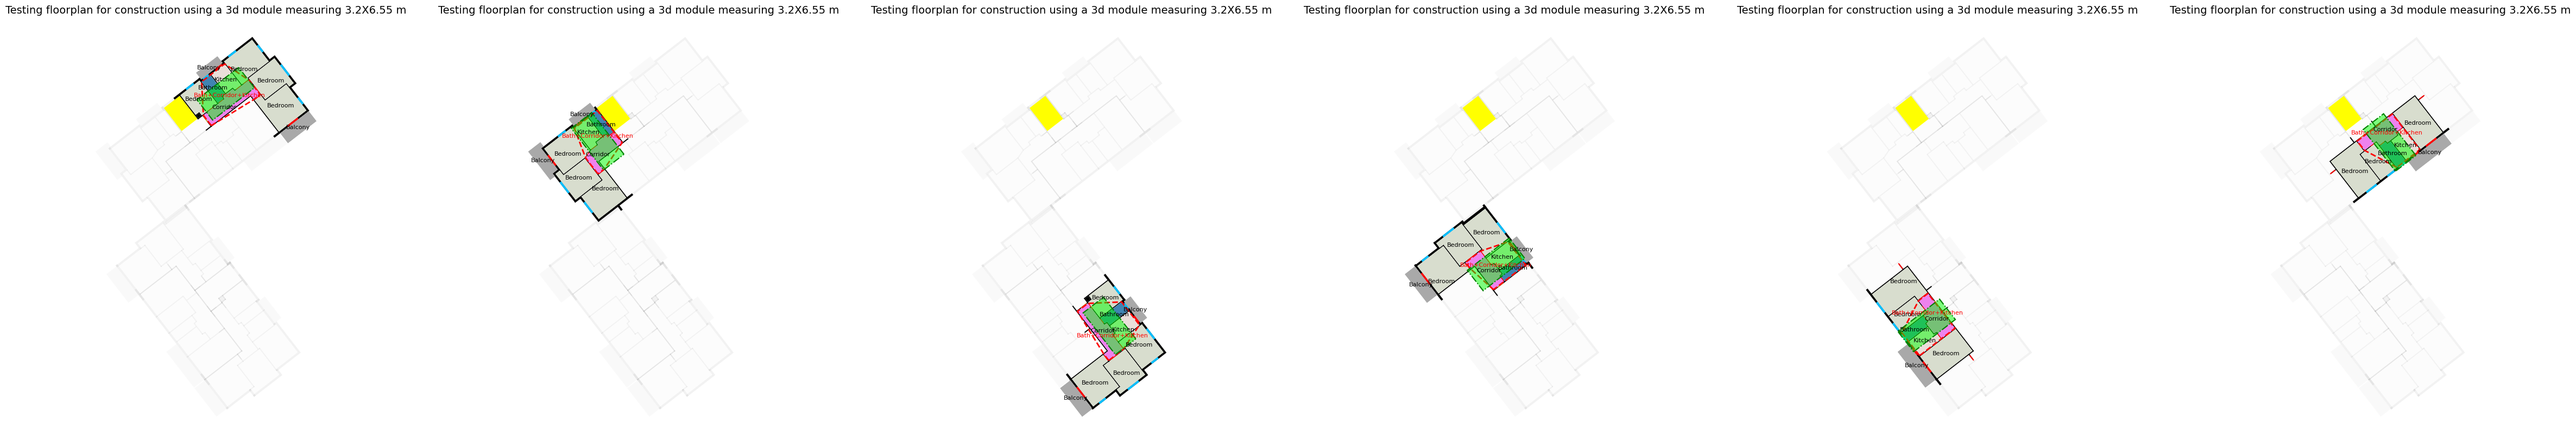


=== Per-Apartment Scores ===
                       apartment_id     score
0  35d1b3b91e69b866d7ff27242e5f084e  0.496776
1  a8555a70fbde32a273a4adb37455432b  0.657447
2  b6a44ed8959d732f0b7c730a37d64d47  0.494689
3  3cd99184d26f256db0da99b46978d2c1  0.666005
4  62d0b17bd97cb1bf168a29b57441abdd  0.551061
5  48c9332d9e12034913f66967d7c90f2b  0.547150

=== Overall Floorplan Average Score: 0.59 ===


In [ ]:
#Ve 01A - COMPARISON- SIMILARITY - WORKING BUT NOT OPTIMALLY
import matplotlib.pyplot as plt
from shapely.geometry import box
from shapely.affinity import translate, rotate
from shapely.ops import unary_union

#Captures a combination of rooms, draws a polyline around and compares to a reference

# --- Assumes the following functions exist ---
# plot_polygon(ax, polygon, **kwargs)
# draw_rooms(ax, geoms, cats, zonings, room_colors, room_names)
# draw_walls_and_openings(ax, geoms, cats, zonings, apartment_ids, colors)

#size of 3d module
moduleWidth =  3.20
moduleLength = 6.55


# Configuration
fs = 10
nc = len(apartments)
fig, axs = plt.subplots(1, nc, figsize=(fs * nc, fs))
axs = axs.flatten()

#dictionary to store scores
per_apartment_scores = {}

# Loop through apartments
for ax, (geoms, cats, zonings), apartment_id in zip(axs, apartments, apartment_ids):

    ax.set_aspect('equal')
    ax.axis('off')

    # Light background context (walls, spaces, etc.)
    _ = [plot_polygon(ax, g, facecolor=colors[0], alpha=0.05) for g in walls]
    _ = [plot_polygon(ax, g, facecolor=colors[4], alpha=0.05) for g in extSpaces]
    _ = [plot_polygon(ax, g, facecolor=colors[4], alpha=0.05) for g in intSpaces]
    _ = [plot_polygon(ax, g, facecolor=colors[8]) for g in cores]

    # Draw architectural elements
    draw_walls_and_openings(ax, geoms, cats, zonings, apartment_ids, colors)
    draw_rooms(ax, geoms, cats, zonings, room_colors, room_names)

    #TO DO IMPROVE THIS - do a loop to try different room combinations
    # --- Custom Room Overlay: Corridor + Bathroom + Kitchen ---
    target_geoms = [g for g, c in zip(geoms, cats) if c in ['Corridor', 'Bathroom', 'Kitchen']]


    if target_geoms:
        merged_geom = unary_union(target_geoms)
        overlay_poly = merged_geom.convex_hull

        # Overlay Polygon: Transparent red
        plot_polygon(ax, overlay_poly, facecolor='none', edgecolor='red', linewidth=2, linestyle='--')

        # Optional label inside overlay
        label_point = overlay_poly.representative_point()
        ax.text(label_point.x, label_point.y, "Bath+Corridor+Kitchen", color='red', fontsize=8, ha='center')

        #Step 1: Compute rotated bounding box
        rot_rect = overlay_poly.minimum_rotated_rectangle

        # Step 2: Get angle of rotation
        coords = list(rot_rect.exterior.coords)
        edge_vec = np.array(coords[1]) - np.array(coords[0])
        angle = np.degrees(np.arctan2(edge_vec[1], edge_vec[0]))
        angle = angle + 90

        # --- Add Reference Polygon which represents the 3d module ---
        # Step 3: Create reference rectangle (e.g., 2m x 3m)
        width = moduleWidth
        length = moduleLength
        ref_poly = box(-width/2, -length/2, width/2, length/2)

        # Step 4: Rotate and translate to center of overlay
        ref_poly = rotate(ref_poly, angle, origin=(0, 0), use_radians=False)
        ref_poly = translate(ref_poly, overlay_poly.centroid.x, overlay_poly.centroid.y)

        # Reference Rectangle: Transparent green
        plot_polygon(ax, ref_poly, facecolor=(0, 1, 0, 0.5), edgecolor='green', linewidth=1.5, linestyle='-.')

        # STEP 5 --- Compute similarity metrics ---
        #area similarity
        area_sim = 1 - abs(ref_poly.area - overlay_poly.area) / max(ref_poly.area, overlay_poly.area)
        #shape similarity
        iou = ref_poly.intersection(overlay_poly).area / ref_poly.union(overlay_poly).area
        #hausdorf distanse
        haus = ref_poly.hausdorff_distance(overlay_poly)
        # --- Single score per apartment ---
        # Hausdorff will be normalized later
        per_apartment_scores[apartment_id] = {
          'apartment_id': apartment_id,
          'area_sim': area_sim,
          'iou': iou,
          'haus': haus
        }

        score_df = pd.DataFrame(per_apartment_scores)


        score_df.to_csv("apartment_module_fit_scores.csv", index=False)
        print("Saved score table to 'apartment_module_fit_scores.csv'")

        # Add  title
        ax.set_title(f"Testing floorplan for construction using a 3d module measuring {moduleWidth}X{moduleLength} m", fontsize=14)
        # Add subtitle below the title
        #ax.text(0.0, -0.15, score_text, fontsize=12, ha='left', va='top', transform=ax.transAxes)
        #ax.set_title(f"Similarty Scores for Apt with ID: {apartment_id}\n{score_text}", fontsize=10)

        # Example similarity explanation (after computing iou, area_sim, haus)
        score_text = (
            f"Similarity Scores for Apt with ID: {apartment_id}\n"
            f"M1-Area Similarity: {area_sim:.2f} \n"
            f"M2-IoU=Overlap ratio: {iou:.2f}  \n"
            f"M3-Boundary similarity(Hausdorff distance): {haus:.2f} "
        )


# --- Create DataFrame and compute final scores ---
score_df = pd.DataFrame(per_apartment_scores.values())

if not score_df.empty:

    # Normalize Hausdorff and compute composite score
    max_haus = score_df['haus'].max() or 1.0  # avoid division by zero
    score_df['score'] = (
        0.4 * score_df['area_sim'] +
        0.4 * score_df['iou'] +
        0.2 * (1 - score_df['haus'] / max_haus)
    )

    # Save to CSV
    score_df.to_csv("apartment_module_fit_scores.csv", index=False)
    print("Saved score table to 'apartment_module_fit_scores.csv'")

    plt.show()
    # Optional print
    print("\n=== Per-Apartment Scores ===")
    print(score_df[['apartment_id', 'score']])
    print(f"\n=== Overall Floorplan Average Score: {avg_score:.2f} ===")

else:
    print("No apartment scores were computed.")


# Display



Saved score table to 'apartment_module_fit_scores.csv'
                       apartment_id              combo     score
0  35d1b3b91e69b866d7ff27242e5f084e  Corridor+Bathroom  0.478673
1  a8555a70fbde32a273a4adb37455432b  Corridor+Bathroom  0.586652
2  b6a44ed8959d732f0b7c730a37d64d47   Corridor+Kitchen  0.516729
3  3cd99184d26f256db0da99b46978d2c1  Corridor+Bathroom  0.583674
4  62d0b17bd97cb1bf168a29b57441abdd  Corridor+Bathroom  0.606569
5  48c9332d9e12034913f66967d7c90f2b  Corridor+Bathroom  0.578888


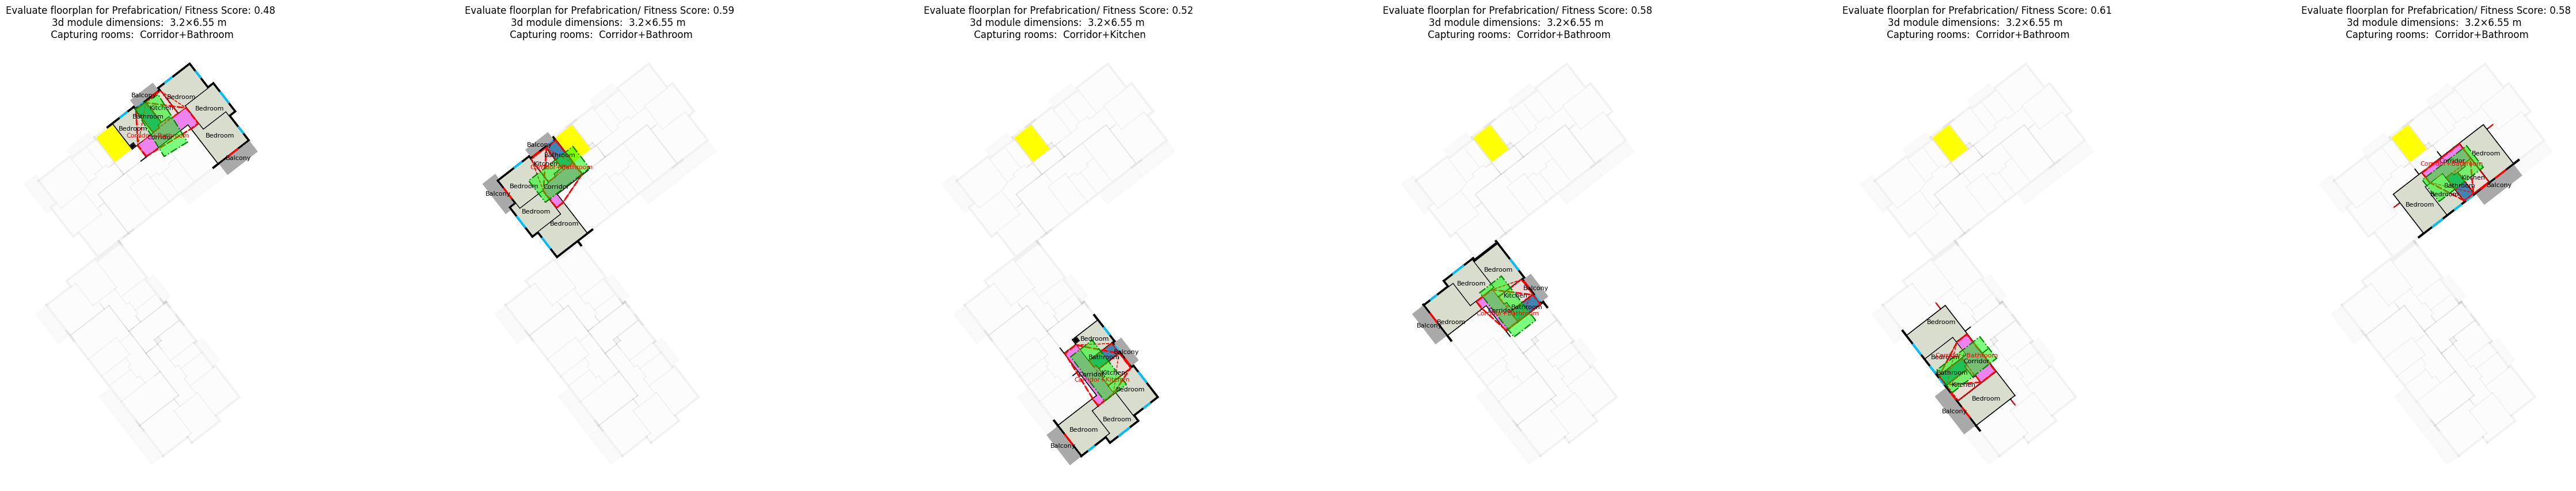

In [ ]:
#Ve 01 B  - COMPARISON- SIMILARITY - WORKING BETTER for identifying room combinations

import matplotlib.pyplot as plt
from shapely.geometry import box
from shapely.affinity import translate, rotate
from shapely.ops import unary_union
import numpy as np
import pandas as pd

# --- Configurations ---
moduleWidth = 3.20
moduleLength = 6.55

room_combinations = [
    ['Corridor', 'Bathroom', 'Kitchen'],
    ['Kitchen', 'Bathroom', 'Bathroom'],
    ['Corridor', 'Bathroom'],
    ['Bathroom', 'Kitchen'],
    ['Corridor', 'Kitchen'],
    ['Bathroom'],
    ['Kitchen']
]

fs = 10
nc = len(apartments)
fig, axs = plt.subplots(1, nc, figsize=(fs * nc, fs))
axs = axs.flatten()

per_apartment_scores = {}

for ax, (geoms, cats, zonings), apartment_id in zip(axs, apartments, apartment_ids):

    ax.set_aspect('equal')
    ax.axis('off')

    # Background context - walls, spaces, cores
    _ = [plot_polygon(ax, g, facecolor=colors[0], alpha=0.05) for g in walls]
    _ = [plot_polygon(ax, g, facecolor=colors[4], alpha=0.05) for g in extSpaces]
    _ = [plot_polygon(ax, g, facecolor=colors[4], alpha=0.05) for g in intSpaces]
    _ = [plot_polygon(ax, g, facecolor=colors[8]) for g in cores]

    # Architectural details
    draw_walls_and_openings(ax, geoms, cats, zonings, apartment_ids, colors)
    draw_rooms(ax, geoms, cats, zonings, room_colors, room_names)

    best_score = -1
    best_result = None

    # Loop over multiple room combinations
    for combo in room_combinations:

        target_geoms = [g for g, c in zip(geoms, cats) if c in combo]

        if not target_geoms:
            continue

        merged_geom = unary_union(target_geoms)
        overlay_poly = merged_geom.convex_hull

        # Plot overlay polygon for current combo (optional)
        plot_polygon(ax, overlay_poly, facecolor='none', edgecolor='red', linewidth=1, linestyle='--')

        # Step 1: Compute rotated bounding box & angle
        rot_rect = overlay_poly.minimum_rotated_rectangle
        coords = list(rot_rect.exterior.coords)
        edge_vec = np.array(coords[1]) - np.array(coords[0])
        angle = np.degrees(np.arctan2(edge_vec[1], edge_vec[0]))
        #angle += 90  # rotate by 90 degrees as you had

        # Step 2: Create reference rectangle (3D module)
        ref_poly = box(-moduleWidth/2, -moduleLength/2, moduleWidth/2, moduleLength/2)
        ref_poly = rotate(ref_poly, angle, origin=(0,0), use_radians=False)
        ref_poly = translate(ref_poly, overlay_poly.centroid.x, overlay_poly.centroid.y)

        # Step 3: Compute similarity metrics
        area_sim = 1 - abs(ref_poly.area - overlay_poly.area) / max(ref_poly.area, overlay_poly.area)
        iou = ref_poly.intersection(overlay_poly).area / ref_poly.union(overlay_poly).area
        haus = ref_poly.hausdorff_distance(overlay_poly)

        # Calculate composite score (adjust weights if needed)
        score = 0.4 * area_sim + 0.4 * iou + 0.2 * (1 - haus / max(haus, 1e-6))

        # Update best combo if score improved
        if score > best_score:
            best_score = score
            best_result = {
                'apartment_id': apartment_id,
                'combo': '+'.join(combo),
                'area_sim': area_sim,
                'iou': iou,
                'haus': haus,
                'score': score,
                'overlay_poly': overlay_poly,
                'ref_poly': ref_poly,
                'angle': angle
            }

    # Plot best result overlays on this apartment's plot
    if best_result is not None:
        # Overlay polygon - red dashed
        plot_polygon(ax, best_result['overlay_poly'], facecolor='none', edgecolor='red', linewidth=2, linestyle='--')

        # Reference polygon - semi-transparent green
        plot_polygon(ax, best_result['ref_poly'], facecolor=(0,1,0,0.5), edgecolor='green', linewidth=1.5, linestyle='-.')

        label_point = best_result['overlay_poly'].representative_point()
        ax.text(label_point.x, label_point.y, best_result['combo'], color='red', fontsize=8, ha='center')

        # Save best scores
        per_apartment_scores[apartment_id] = best_result

        # Add title for apartment plot
        ax.set_title(
            f"Evaluate floorplan for Prefabrication/ Fitness Score: {best_result['score']:.2f}\n"
            f"3d module dimensions:  {moduleWidth}×{moduleLength} m \n Capturing rooms:  {best_result['combo']}",
            fontsize=12
        )
    else:
        ax.set_title("No valid room combination found", fontsize=12)

# Create DataFrame from results
score_df = pd.DataFrame(per_apartment_scores.values())





# Save results
if not score_df.empty:
    score_df.to_csv("apartment_module_fit_scores.csv", index=False)
    print("Saved score table to 'apartment_module_fit_scores.csv'")
    print(score_df[['apartment_id', 'combo', 'score']])

plt.show()


NameError: name 'get_geometries_from_id' is not defined

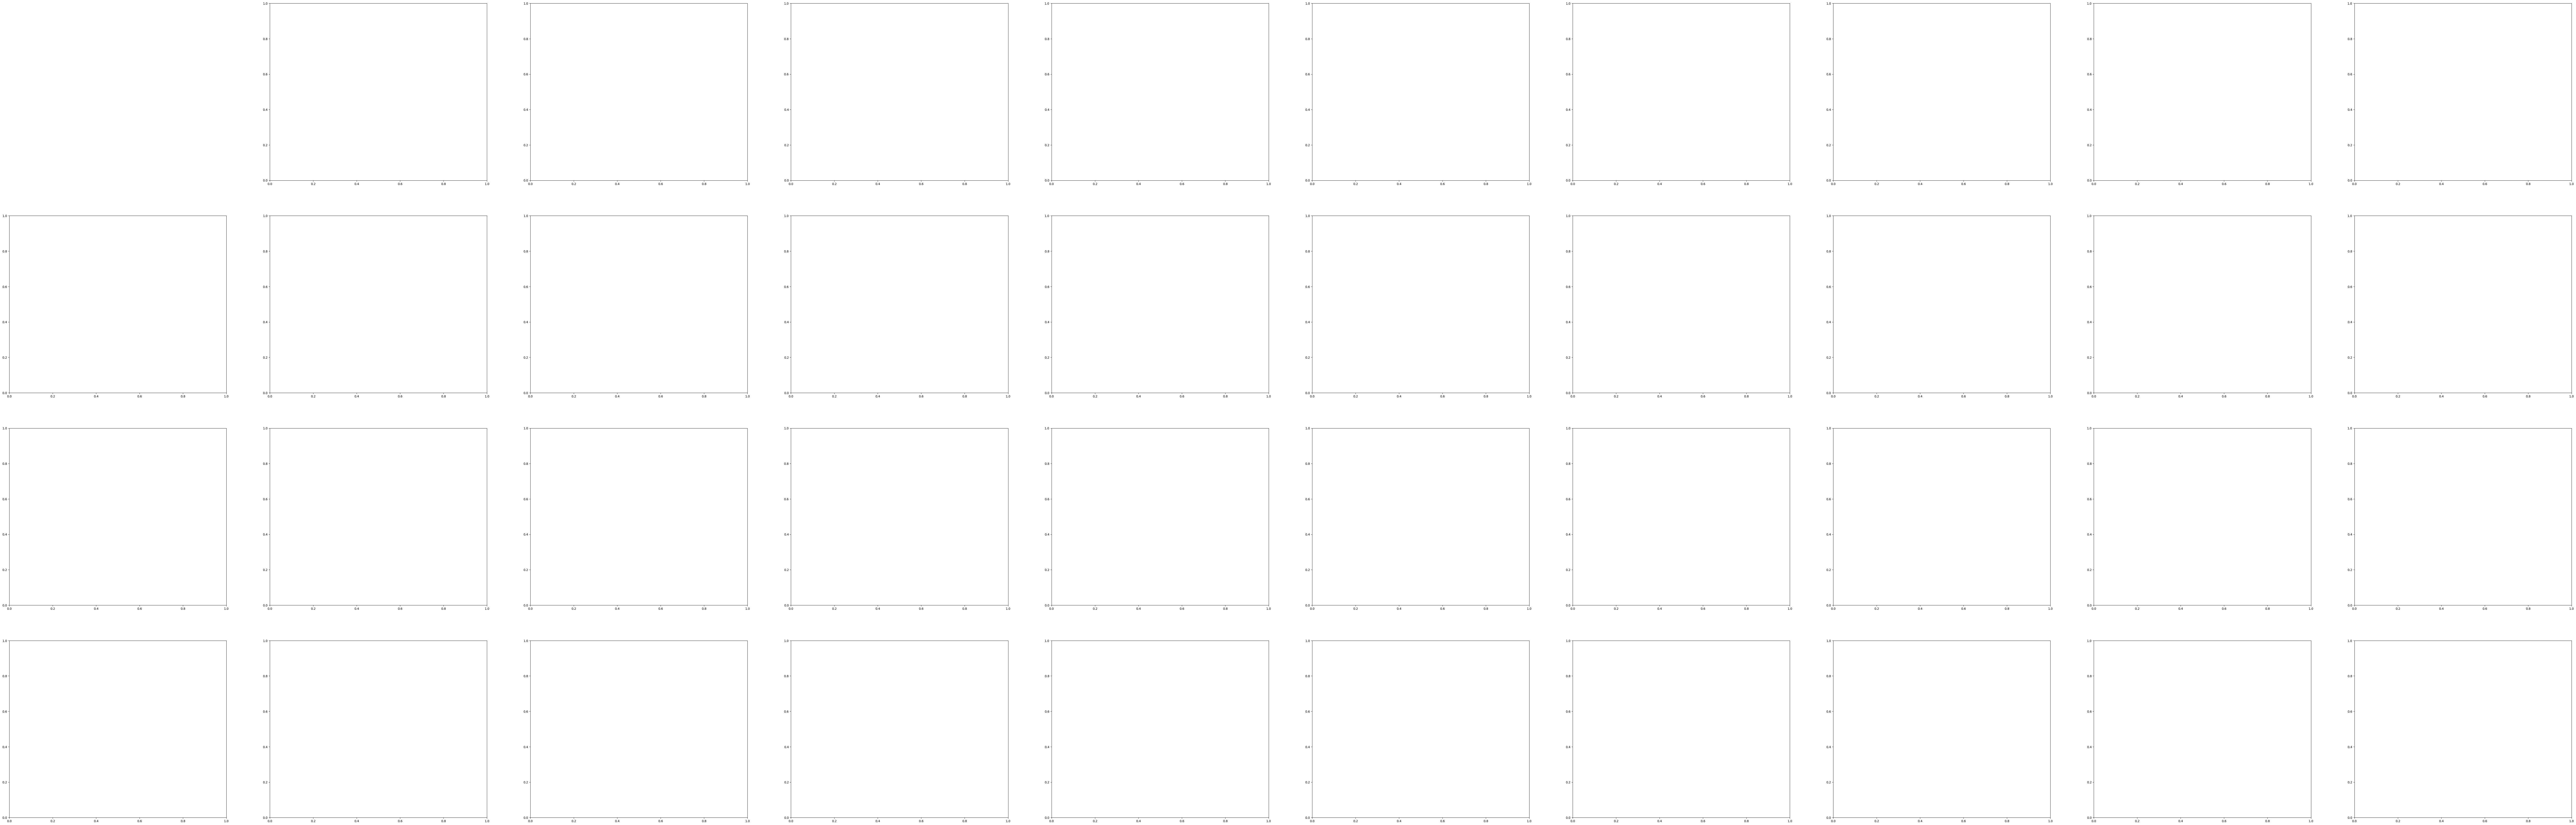

In [ ]:
# VE 1D getting SIMILARITY SCORE on different floorplans- WORKING WELL
#NEED TO DO -> Get a list of aparments that fit certain criteria i.e. storeys 2<5  / area

# NEED TO DO - EXPORT THE RESULTS in csv + an image for each
import matplotlib.pyplot as plt
from shapely.geometry import box
from shapely.affinity import translate, rotate
from shapely.ops import unary_union
import pandas as pd
import numpy as np

# Assume DF, get_geometries_from_id, draw_walls_and_openings, draw_rooms, plot_polygon, get_edges_angles_from_rooms,
# generate_candidate_angles, colors, room_colors, room_names are defined.

#SETUP
selectedbuildingNumber = [10, 20, 25, 30, 50, 60,70, 80,90,100,110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 340, 560, 550, 1000, 343, 540, 670, 54, 56, 59, 85, 77, 114, 134, 179, 300]
selectedFloor = 0
building_ids = list(DF.building_id.dropna().unique())

#3d Module
moduleWidth = 3.20
moduleLength = 6.55

score_threshold = 0.8  # Set your threshold here

#combinations of spaces that may be fit for testing the positioning of a 3d module
room_combinations = [
    ['Corridor', 'Bathroom', 'Kitchen'],
    ['Corridor', 'Bathroom', 'Bathroom'],
    ['Corridor', 'Storage', 'Bathroom'],
    ['Corridor', 'Kitchen'],
    ['Bathroom', 'Kitchen'],
    ['Corridor', 'Bathroom'],
]

#set up for the plotting
n_buildings = len(selectedbuildingNumber)
cols = 10
rows = (n_buildings + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols * 15, rows * 12))
axes = axes.flatten()


# Function to get all room edge angles
def get_edges_angles_from_rooms(room_polygons):
    angles = []
    for poly in room_polygons:
        coords = list(poly.exterior.coords)
        for i in range(len(coords) - 1):
            p1 = coords[i]
            p2 = coords[i + 1]
            dx = p2[0] - p1[0]
            dy = p2[1] - p1[1]
            angle = np.degrees(np.arctan2(dy, dx)) % 180  # 0-180 degrees
            angles.append(angle)
    return angles

def generate_candidate_angles(room_angles):
    candidates = set()
    for a in room_angles:
        candidates.add(a % 180)
        candidates.add((a + 90) % 180)
    return sorted(candidates)


for ax_idx, b_idx in enumerate(selectedbuildingNumber):
    ax = axes[ax_idx]
    ax.set_aspect('equal')
    ax.axis('off')

    building_id = building_ids[b_idx]
    floor_ids = list(DF[DF.building_id == building_id].floor_id.dropna().unique())
    floor_id = floor_ids[selectedFloor]

    apartment_ids = list(DF[(DF.building_id == building_id) & (DF.floor_id == floor_id)].apartment_id.dropna().unique())
    apartments = []
    #loop through all apartments
    for apartment_id in apartment_ids:
        geoms_ap, cats_ap, zonings_ap = get_geometries_from_id(DF, building_id, floor_id, apartment_id)
        apartments.append([geoms_ap, cats_ap, zonings_ap])

    # Plot floor background
    geoms, cats, zonings = get_geometries_from_id(DF, building_id, floor_id)
    walls = [g for g, c in zip(geoms, cats) if c == 'Wall']
    extSpaces = [g for g, c in zip(geoms, cats) if c == 'ExteriorSpace']
    intSpaces = [g for g, c in zip(geoms, cats) if c == 'InteriorSpace']
    cores = [g for g, c in zip(geoms, cats) if c == 'Core']

    for g in walls:
        plot_polygon(ax, g, facecolor=colors[0], alpha=0.05)
    for g in extSpaces:
        plot_polygon(ax, g, facecolor=colors[4], alpha=0.05)
    for g in intSpaces:
        plot_polygon(ax, g, facecolor=colors[4], alpha=0.05)
    for g in cores:
        plot_polygon(ax, g, facecolor=colors[8])

    per_apartment_scores = {}

    # --- NEW: Calculate max_haus across all apartments and room combinations ---
    all_haus = []
    for (geoms, cats, zonings), apartment_id in zip(apartments, apartment_ids):
        for room_types in room_combinations:
            target_geoms = [g for g, c in zip(geoms, cats) if c in room_types]
            if not target_geoms:
                continue
            merged_geom = unary_union(target_geoms)
            overlay_poly = merged_geom.convex_hull

            room_edge_angles = get_edges_angles_from_rooms(target_geoms)
            candidate_angles = generate_candidate_angles(room_edge_angles)

            ref_template = box(-moduleWidth/2, -moduleLength/2, moduleWidth/2, moduleLength/2)

            best_haus = None
            for angle_candidate in candidate_angles:
                rotated_ref = rotate(ref_template, angle_candidate, origin=(0, 0), use_radians=False)
                moved_ref = translate(rotated_ref, overlay_poly.centroid.x, overlay_poly.centroid.y)
                haus = moved_ref.hausdorff_distance(overlay_poly)
                if best_haus is None or haus < best_haus:
                    best_haus = haus
            if best_haus is not None:
                all_haus.append(best_haus)

    max_haus = max(all_haus) if all_haus else 1
    # --- END NEW ---

    for (geoms, cats, zonings), apartment_id in zip(apartments, apartment_ids):
        draw_walls_and_openings(ax, geoms, cats, zonings, apartment_ids, colors)
        draw_rooms(ax, geoms, cats, zonings, room_colors, room_names)

        best_combination_score = -1
        best_combination_details = None

        for room_types in room_combinations:
            target_geoms = [g for g, c in zip(geoms, cats) if c in room_types]
            if not target_geoms:
                continue

            merged_geom = unary_union(target_geoms)
            overlay_poly = merged_geom.convex_hull

            room_edge_angles = get_edges_angles_from_rooms(target_geoms)
            candidate_angles = generate_candidate_angles(room_edge_angles)

            ref_template = box(-moduleWidth/2, -moduleLength/2, moduleWidth/2, moduleLength/2)

            best_iou = -1
            best_angle = None
            best_ref_poly = None

            for angle_candidate in candidate_angles:
                rotated_ref = rotate(ref_template, angle_candidate, origin=(0, 0), use_radians=False)
                moved_ref = translate(rotated_ref, overlay_poly.centroid.x, overlay_poly.centroid.y)

                inter_area = moved_ref.intersection(overlay_poly).area
                union_area = moved_ref.union(overlay_poly).area
                iou = inter_area / union_area if union_area != 0 else 0

                if iou > best_iou:
                    best_iou = iou
                    best_angle = angle_candidate
                    best_ref_poly = moved_ref

            area_sim = 1 - abs(best_ref_poly.area - overlay_poly.area) / max(best_ref_poly.area, overlay_poly.area)
            haus = best_ref_poly.hausdorff_distance(overlay_poly)

            score = 0.4 * area_sim + 0.4 * best_iou + 0.2 * (1 - haus / max_haus)  # <-- changed here

            if score > best_combination_score:
                best_combination_score = score
                best_combination_details = {
                    'overlay_poly': overlay_poly,
                    'best_ref_poly': best_ref_poly,
                    'iou': best_iou,
                    'area_sim': area_sim,
                    'haus': haus,
                    'angle': best_angle,
                    'score': score,
                    'room_types': room_types,
                }

        if best_combination_score < score_threshold:
            # Skip plotting apartments below threshold
            continue

        # Plot overlays only for apartments above threshold
        plot_polygon(ax, best_combination_details['overlay_poly'], facecolor='none', edgecolor='red', linewidth=1, linestyle='--')
        plot_polygon(ax, best_combination_details['best_ref_poly'], facecolor=(0, 1, 0, 0.3), edgecolor='green', linewidth=1, linestyle='-.')

        per_apartment_scores[apartment_id] = {
            'apartment_id': apartment_id,
            'area_sim': best_combination_details['area_sim'],
            'iou': best_combination_details['iou'],
            'haus': best_combination_details['haus'],
            'angle': best_combination_details['angle'],
            'score': best_combination_score,
            'room_types': best_combination_details['room_types'],
        }

    count_above_threshold = len(per_apartment_scores)
    print(f"Building {building_id} Floor {floor_id}: {count_above_threshold} apartments above threshold ({score_threshold})")

    score_df = pd.DataFrame(per_apartment_scores.values())
    if not score_df.empty:
        avg_score = score_df['score'].mean()
    else:
        avg_score = 0

    ax.set_title(f"Building {building_id} Floor {floor_id}\nAverage Score: {avg_score:.2f}", fontsize=14)


# Hide unused subplots if any
for i in range(n_buildings, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
#VE 2 - not happy with itt!!!!!!!!!!!!!!!!!!!!!!

import matplotlib.pyplot as plt
from shapely.geometry import box
from shapely.affinity import translate, rotate
from shapely.ops import unary_union
import numpy as np
import pandas as pd

moduleWidth = 3.20
moduleLength = 6.55

# Function to get all room edge angles
def get_edges_angles_from_rooms(room_polygons):
    angles = []
    for poly in room_polygons:
        coords = list(poly.exterior.coords)
        for i in range(len(coords) - 1):
            p1 = coords[i]
            p2 = coords[i + 1]
            dx = p2[0] - p1[0]
            dy = p2[1] - p1[1]
            angle = np.degrees(np.arctan2(dy, dx)) % 180  # 0-180 degrees
            angles.append(angle)
    return angles

def generate_candidate_angles(room_angles):
    candidates = set()
    for a in room_angles:
        candidates.add(a % 180)
        candidates.add((a + 90) % 180)
    return sorted(candidates)

def compute_best_fit_and_score(geoms, cats):
    target_geoms = [g for g, c in zip(geoms, cats) if c in ['Corridor', 'Bathroom', 'Kitchen']]
    if not target_geoms:
        return None

    merged_geom = unary_union(target_geoms)
    overlay_poly = merged_geom.convex_hull

    room_edge_angles = get_edges_angles_from_rooms(target_geoms)
    candidate_angles = generate_candidate_angles(room_edge_angles)

    ref_template = box(-moduleWidth/2, -moduleLength/2, moduleWidth/2, moduleLength/2)

    best_iou = -1
    best_angle = None
    best_ref_poly = None

    for angle_candidate in candidate_angles:
        rotated_ref = rotate(ref_template, angle_candidate, origin=(0, 0), use_radians=False)
        moved_ref = translate(rotated_ref, overlay_poly.centroid.x, overlay_poly.centroid.y)
        inter_area = moved_ref.intersection(overlay_poly).area
        union_area = moved_ref.union(overlay_poly).area
        iou = inter_area / union_area if union_area != 0 else 0
        if iou > best_iou:
            best_iou = iou
            best_angle = angle_candidate
            best_ref_poly = moved_ref

    if best_ref_poly is None:
        return None

    area_sim = 1 - abs(best_ref_poly.area - overlay_poly.area) / max(best_ref_poly.area, overlay_poly.area)
    haus = best_ref_poly.hausdorff_distance(overlay_poly)

    score_data = {
        'area_sim': area_sim,
        'iou': best_iou,
        'haus': haus,
        'angle': best_angle,
        'overlay_poly': overlay_poly,
        'best_ref_poly': best_ref_poly
    }

    return score_data


# Main loop over buildings and floors
all_scores = []

# Example: buildings_data = [(apartments1, apartment_ids1), (apartments2, apartment_ids2), ...]
# Make sure you have a list or dict structure of buildings with their apartments

for building_idx, (apartments, apartment_ids) in enumerate(buildings_data):

    for (geoms, cats, zonings), apartment_id in zip(apartments, apartment_ids):
        score_result = compute_best_fit_and_score(geoms, cats)
        if score_result is None:
            continue

        area_sim = score_result['area_sim']
        iou = score_result['iou']
        haus = score_result['haus']
        angle = score_result['angle']

        all_scores.append({
            'building_idx': building_idx,
            'apartment_id': apartment_id,
            'area_sim': area_sim,
            'iou': iou,
            'haus': haus,
            'angle': angle,
            'overlay_poly': score_result['overlay_poly'],
            'best_ref_poly': score_result['best_ref_poly']
        })

# Convert to DataFrame for scoring
score_df = pd.DataFrame(all_scores)
if not score_df.empty:
    max_haus = score_df['haus'].max() or 1.0
    score_df['score'] = (
        0.4 * score_df['area_sim'] +
        0.4 * score_df['iou'] +
        0.2 * (1 - score_df['haus'] / max_haus)
    )
    score_df.to_csv("all_buildings_module_fit_scores.csv", index=False)
    print("Saved score table to 'all_buildings_module_fit_scores.csv'")

# Plot apartments with score > 0.7
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_aspect('equal')
ax.axis('off')

# Plot background (walls, spaces, cores) - Assuming you have building-level background data accessible or skip here

for idx, row in score_df.iterrows():
    if row['score'] > 0.7:
        plot_polygon(ax, row['overlay_poly'], facecolor='none', edgecolor='red', linewidth=1, linestyle='--')
        plot_polygon(ax, row['best_ref_poly'], facecolor=(0, 1, 0, 0.3), edgecolor='green', linewidth=1, linestyle='-.')

ax.set_title("Apartments with Score > 0.7 and Module Overlay", fontsize=16)
plt.show()


In [ ]:
#VE2B not working well



import matplotlib.pyplot as plt
from shapely.geometry import box
from shapely.affinity import translate, rotate
from shapely.ops import unary_union
import numpy as np
import pandas as pd

# -- Configuration --
moduleWidth = 3.20
moduleLength = 6.55
room_combinations = [
    ['Corridor', 'Bathroom', 'Kitchen'],
    ['Corridor', 'Bathroom'],
    ['Kitchen', 'Bathroom'],
    ['Corridor', 'Kitchen'],
    ['Bathroom'],
    ['Kitchen']
]

fs = 10
nc = len(apartments)
fig, axs = plt.subplots(1, nc, figsize=(fs * nc, fs))
axs = axs.flatten()
per_apartment_scores = {}

# To avoid overlapping buildings, you can define an offset step (e.g., shift by 20m on x axis per building)
x_offset_step = 20


for b_i, idx in enumerate(selectedbuildingNumber):
    building_id = building_ids[idx]
    floor_ids = list(DF[DF.building_id == building_id].floor_id.dropna().unique())
    floor_id = floor_ids[selectedFloor]

    apartment_ids = list(DF[(DF.building_id == building_id) & (DF.floor_id == floor_id)].apartment_id.dropna().unique())
    print(f"Processing building {building_id}, floor {floor_id}, apartments: {len(apartment_ids)}")

    # Apply offset to geometries to separate buildings visually
    offset_x = b_i * x_offset_step

    for apartment_id in apartment_ids:
        geoms, cats, zonings = get_geometries_from_id(DF, building_id, floor_id, apartment_id)

         # You probably get walls, extSpaces, etc. here per building/floor:
        walls, extSpaces, intSpaces, cores = get_floor_elements(building_id, floor_id)  # example

        # Apply x-offset to separate buildings in plot
        offset_x = b_i * 20

        # Plot background elements for current building/floor with offset
        for g in walls:
            plot_polygon(ax, translate(g, xoff=offset_x), facecolor=colors[0], alpha=0.05)
        for g in extSpaces:
            plot_polygon(ax, translate(g, xoff=offset_x), facecolor=colors[4], alpha=0.05)
        for g in intSpaces:
            plot_polygon(ax, translate(g, xoff=offset_x), facecolor=colors[4], alpha=0.05)
        for g in cores:
            plot_polygon(ax, translate(g, xoff=offset_x), facecolor=colors[8])

        geoms_offset = [translate(g, xoff=offset_x, yoff=0) for g in geoms]

        # Draw walls, openings, rooms with offset geometries
        draw_walls_and_openings(ax, geoms_offset, cats, zonings, apartment_ids, colors)
        draw_rooms(ax, geoms_offset, cats, zonings, room_colors, room_names)

        # Target rooms to merge (offset)
        target_geoms = [g for g, c in zip(geoms_offset, cats) if c in ['Corridor', 'Bathroom', 'Kitchen']]
        if not target_geoms:
            continue

        merged_geom = unary_union(target_geoms)
        overlay_poly = merged_geom.convex_hull

        # Get all edges angles from the individual rooms (using original geoms, no offset, so angles are accurate)
        room_edge_angles = get_edges_angles_from_rooms([g for g, c in zip(geoms, cats) if c in ['Corridor', 'Bathroom', 'Kitchen']])
        candidate_angles = generate_candidate_angles(room_edge_angles)

        ref_template = box(-moduleWidth/2, -moduleLength/2, moduleWidth/2, moduleLength/2)

        best_iou = -1
        best_angle = None
        best_ref_poly = None

        for angle_candidate in candidate_angles:
            rotated_ref = rotate(ref_template, angle_candidate, origin=(0, 0), use_radians=False)
            # Move to overlay centroid + offset
            moved_ref = translate(rotated_ref, overlay_poly.centroid.x + offset_x, overlay_poly.centroid.y)

            inter_area = moved_ref.intersection(overlay_poly).area
            union_area = moved_ref.union(overlay_poly).area
            iou = inter_area / union_area if union_area != 0 else 0

            if iou > best_iou:
                best_iou = iou
                best_angle = angle_candidate
                best_ref_poly = moved_ref

        # Plot overlay polygon and best fitting reference polygon
        plot_polygon(ax, overlay_poly, facecolor='none', edgecolor='red', linewidth=1, linestyle='--')
        plot_polygon(ax, best_ref_poly, facecolor=(0, 1, 0, 0.3), edgecolor='green', linewidth=1, linestyle='-.')

        area_sim = 1 - abs(best_ref_poly.area - overlay_poly.area) / max(best_ref_poly.area, overlay_poly.area)
        haus = best_ref_poly.hausdorff_distance(overlay_poly)

        per_apartment_scores[apartment_id] = {
            'apartment_id': apartment_id,
            'area_sim': area_sim,
            'iou': best_iou,
            'haus': haus,
            'angle': best_angle,
            'building_id': building_id,
            'floor_id': floor_id
        }


# Create DataFrame and save scores
score_df = pd.DataFrame(per_apartment_scores.values())
if not score_df.empty:
    max_haus = score_df['haus'].max() or 1.0
    score_df['score'] = (
        0.4 * score_df['area_sim'] +
        0.4 * score_df['iou'] +
        0.2 * (1 - score_df['haus'] / max_haus)
    )
    avg_score = score_df['score'].mean()
    print(avg_score)
    score_df.to_csv("apartment_module_fit_scores_multiple_buildings.csv", index=False)
    print("Saved score table to 'apartment_module_fit_scores_multiple_buildings.csv'")

ax.set_title(f"Floorplans with 3D Module Overlays (Multiple Buildings)\n"
             f"Average Score: {avg_score:.2f}", fontsize=14)

plt.show()

In [ ]:
#Ve 02 -- COMPARISON- SIMILARITY UPDATED

import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import box
from shapely.affinity import translate, rotate
from shapely.ops import unary_union
import pandas as pd

# Parameters
moduleWidth = 3.20
moduleLength = 6.55
target_area_threshold = moduleWidth * moduleLength * 0.9  # For example, must be at least 90% filled

# Score accumulators
iou_scores, area_sims, haus_dists = [], [], []

# Plotting setup
fs = 10
nc = len(apartments)
fig, axs = plt.subplots(1, nc, figsize=(fs * nc, fs))
axs = axs.flatten()

#dicitionary to store scores
per_apartment_scores = {}


for ax, (apartment_data, apartment_id) in zip(axs, zip(apartments, apartment_ids)):

    apt_geoms, apt_cats, apt_zonings = apartment_data
    ax.set_title(f"Apartment {apartment_id}")
    ax.set_aspect('equal')
    ax.axis('off')
    # Background layers
    _ = [plot_polygon(ax, g, facecolor=colors[0], alpha=0.05) for g in walls]
    _ = [plot_polygon(ax, g, facecolor=colors[4], alpha=0.05) for g in extSpaces]
    _ = [plot_polygon(ax, g, facecolor=colors[4], alpha=0.05) for g in intSpaces]
    _ = [plot_polygon(ax, g, facecolor=colors[8]) for g in cores]



    draw_walls_and_openings(ax, apt_geoms, apt_cats, apt_zonings, [apartment_id], colors)
    draw_rooms(ax, apt_geoms, apt_cats, apt_zonings, room_colors, room_names)

    # --- Smart Room Selection ---
    target_geoms = [g for g, c in zip(apt_geoms, apt_cats) if c == 'Bathroom']
    selected_labels = ['Bathroom']
    total_area = sum(g.area for g in target_geoms)

    room_priority = ['Corridor', 'Kitchen', 'Storeroom']


    for room in room_priority:
        # Add only one geometry at a time
        for g, c in zip(geoms, cats):
            if c == room and g not in target_geoms:
                target_geoms.append(g)
                selected_labels.append(c)
                total_area = sum(g.area for g in target_geoms)
                if total_area >= target_area_threshold:
                    break
        if total_area >= target_area_threshold:
            break

    if not target_geoms:
        continue  # Skip this apartment if nothing to compare

    # --- Merge and compare ---
    merged_geom = unary_union(target_geoms)
    overlay_poly = merged_geom.convex_hull

    # Plot overlay polygon
    plot_polygon(ax, overlay_poly, facecolor='none', edgecolor='red', linewidth=2, linestyle='--')

    # Bounding box angle
    rot_rect = overlay_poly.minimum_rotated_rectangle
    coords = list(rot_rect.exterior.coords)
    edge_vec = np.array(coords[1]) - np.array(coords[0])
    angle = np.degrees(np.arctan2(edge_vec[1], edge_vec[0])) + 90

    # Reference rectangle (3D module)
    ref_poly = box(-moduleWidth / 2, -moduleLength / 2, moduleWidth / 2, moduleLength / 2)
    ref_poly = rotate(ref_poly, angle, origin=(0, 0), use_radians=False)
    ref_poly = translate(ref_poly, overlay_poly.centroid.x, overlay_poly.centroid.y)

    plot_polygon(ax, ref_poly, facecolor=(0, 1, 0, 0.5), edgecolor='green', linewidth=1.5, linestyle='-.')

    # --- Scores ---
    area_sim = 1 - abs(ref_poly.area - overlay_poly.area) / max(ref_poly.area, overlay_poly.area)
    iou = ref_poly.intersection(overlay_poly).area / ref_poly.union(overlay_poly).area
    haus = ref_poly.hausdorff_distance(overlay_poly)

    # Collect for stats
    iou_scores.append(iou)
    area_sims.append(area_sim)
    haus_dists.append(haus)



    # --- Single score per apartment ---
    # Hausdorff will be normalized later
    per_apartment_scores[apartment_id] = {
      'apartment_id': apartment_id,
      'area_sim': area_sim,
      'iou': iou,
      'haus': haus
    }

    score_df = pd.DataFrame(per_apartment_scores)
    # Score label
    score_text = (
        f"Apt ID: {apartment_id} | Rooms: {', '.join(selected_labels)}\n"
        f"Area Sim: {area_sim:.2f} | IoU: {iou:.2f} | Hausdorff: {haus:.2f}"
    )
    ax.set_title(f"Module Fit Assessment\n3D module: {moduleWidth}×{moduleLength} m", fontsize=11)
    ax.text(0, -0.15, score_text, fontsize=10, ha='left', va='top', transform=ax.transAxes)

    # --- Create DataFrame and compute final scores ---
    score_df = pd.DataFrame(per_apartment_scores.values())


if not score_df.empty:
    # Normalize Hausdorff and compute composite score
    max_haus = score_df['haus'].max() or 1.0  # avoid division by zero
    score_df['score'] = (
        0.4 * score_df['area_sim'] +
        0.4 * score_df['iou'] +
        0.2 * (1 - score_df['haus'] / max_haus)
    )

    # Save to CSV
    score_df.to_csv("apartment_module_fit_scores.csv", index=False)
    print("Saved score table to 'apartment_module_fit_scores.csv'")

    # --- Bar chart ---
    avg_score = score_df['score'].mean()
    plt.figure(figsize=(12, 6))
    sorted_df = score_df.sort_values('score', ascending=False)

    plt.bar(sorted_df['apartment_id'].astype(str), sorted_df['score'], color='black')
    plt.axhline(y=avg_score, color='red', linestyle='--', label=f'Avg Score: {avg_score:.2f}')
    plt.xlabel("Apartment ID")
    plt.ylabel("Composite Score")
    plt.title("Modular Fit Score for whole Floor")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    plt.show()

    # Optional print
    print("\n=== Per-Apartment Scores ===")
    print(score_df[['apartment_id', 'score']])
    print(f"\n=== Overall Average Score: {avg_score:.2f} ===")

else:
    print("No apartment scores were computed.")


# Display
# Show
#plt.tight_layout()
#plt.show()




## (2) Extracting graphs

Now it is time to extract the graphs.We do this per individual apartment.
For now, we will not bother about the entrances and the windows, and completely focus on the layout of the apartment as if it would be isolated from the rest of the world.

The graph extraction algorithm in this notebook is slightly different from the one the following Github ($\longrightarrow$ [Data Curation Part 2 - Graph Extraction](https://github.com/caspervanengelenburg/msd/blob/main/NB%20-%20Data%20Curation%202%20-%20Graph%20Extraction.ipynb)):

We include more features / attributes to the nodes, edges, and the graph itself (1) and the room categorizations are slightly different (2).
The format of the data stays the same; so, if you already worked with the other graph data, it won't be difficult to modify the code to work with the ones we'll extract here.
The graph extraction algorithm below should be self-explainable from the comments.
We include some more features / attributes to the nodes, edges, and the graph itself (1) and the room categorization is slightly modified (2).
The format of the data stays the same; so, if you already worked with the other graph data, it won't be difficult to modify your code to work with the ones we'll extract here.

Graphs are stored as `nx.Graph()` data structures, which IMHO is one of the easiest-to-work-with graph containers you can find in Python.

One thing to highlight here is the WAY to check the connectivity by doors.
The door geometries are temporarily modified by rotating them 90 degrees and making them slightly smaller.

This means that there is more clearly overlap between the rotated door geometry and the two rooms that the door connects.
This makes the algorithm more robust to slightly misplaced doors.


In [ ]:
from warnings import catch_warnings
from types import NotImplementedType
from copy import deepcopy
from itertools import combinations
import torch
import networkx as nx
from shapely.geometry import Polygon
from shapely.affinity import rotate, scale

def rotate_rectangle(rect: Polygon, scale_factor=0.5, angle=90):
    # Compute centroid (center point)
    centroid = rect.centroid

    # Scale the rectangle (relative to the centroid)
    scaled_rect = scale(rect, xfact=scale_factor, yfact=scale_factor, origin=centroid)

    # Rotate the scaled rectangle around its center
    rotated_rect = rotate(scaled_rect, angle, origin=centroid)

    return rotated_rect

def polygon_to_list(polygon: Polygon) -> list:
    """Converts a polygon into a list of coordinates."""
    return list(zip(*polygon.exterior.coords.xy))

def extract_access_graph(geoms, cats, names, apartment_id, floor_id):
    """Extracts the access graph from a set of geometries."""
    # Sets the mapping
    mapping_names = {cat: i for i, cat in enumerate(names)}

    # Initializes empty lists for rooms and their categories, doors, and walls
    rooms, room_cats, doors, entrances, walls, windows = [], [], [], [], [], []

    # Loops through the geometries and corresponding categories
    for geom, cat in zip(geoms, cats):
        if cat ==  'Door':  # Doors
            doors.append(geom)
        elif cat ==  'Entrance Door':  # Entrances
            doors.append(geom)
            entrances.append(geom)
        elif cat in names[:9]:  # Rooms
            rooms.append(geom)
            room_cats.append(cat)
        elif cat == 'Structure':  # Walls and columns
            walls.append(geom)
        elif cat == 'Window': # Windows
            windows.append(geom)
        else: continue

    # Accumulation of NODES (i.e., the rooms)
    nodes = {}
    for key, (room, cat) in enumerate(zip(rooms, room_cats)):

        # Set node and its attributes
        nodes[key] = {
            'polygon': polygon_to_list(room),
            'category': mapping_names[cat],
            'centroid': torch.tensor(np.array([room.centroid.x, room.centroid.y]))
        }

    # Accumulation of EDGES (i.e., room to room connectivity)
    #TODO DOUBLECHECK THER LOGIC HOW ROOMS CONNECT
    edges = []
    for (i, v1), (j, v2) in combinations(enumerate(rooms), 2):

        # (Option 1) Passage (i.e., direct access := no wall in between)
        if v1.distance(v2) < 0.04:
            edges.append([i, j, {'polygon': None, 'connectivity': 'passage'}])

        # (Option 2) Door (i.e., door in between two rooms)
        else:
            edge = False
            for door in doors + entrances:
                door_rotated = rotate_rectangle(door, scale_factor=1)
                if door_rotated.intersection(v1) and door_rotated.intersection(v2):
                    # Adds the geometry of the door as well (slightly different from paper)
                    edge = True
                    edges.append([i, j, {'polygon': polygon_to_list(door), 'connectivity': 'door'}])
                else: continue

            # (Option 2B) By window (i.e., window between balcony and other room)
            # Sometimes, balconies seem disconnected from the apartment (fully).
            # This is likely not the case. So, if a balcony connects with one of the other rooms
            # through a window it is fine as well.
            if not edge and (room_cats[i] == "Balcony" or room_cats[j] == "Balcony"):
                # Check connection based on window overlap
                for window in windows:
                    window_rotated = rotate_rectangle(window)
                    if window_rotated.intersection(v1) and window_rotated.intersection(v2):
                        edges.append([i, j, {'polygon': polygon_to_list(window), 'connectivity': 'door'}])
                    else: continue

    # Get tightest boundary of the apartment
    # (1) Unite all these wall geometries
    # (2) Find the polygon within the union that is largest in terms of area (using np.argsort)
    #   and choose the largest (which is by default put on the end of the sort)
    structure = unary_union(walls)  # (1)
    if structure.geom_type == "MultiPolygon":
        boundary = structure.geoms[np.argsort([geom.area for geom in structure.geoms])[-1]]  # (2)
    elif structure.geom_type == "Polygon":
        boundary = deepcopy(structure)
    else:
        raise NotImplementedType(f"Not implemented for {structure.geom_type}.")

    # Defines the graph
    G = nx.Graph()
    # Graph attributes / features
    G.graph["Floor ID"] = floor_id  # Floor ID
    G.graph["Apt ID"] = apartment_id  # Apartment ID (i.e., name)
    G.graph["Structure"] = walls  # Walls and columns
    G.graph["Windows"] = windows  # Windows
    G.graph["Entrances"] = entrances  # Entrances (doors)
    # Node attributes / features
    G.add_nodes_from([(u, v) for u, v in nodes.items()])
    # Edge attributes / features
    G.add_edges_from(edges)

    return G

Let's load the graphs in a list called `graphs`:

In [ ]:
from IPython.display import clear_output

# Initialize emtpy list for graphs
graphs = []

# Loop over apartments
for i, ((geoms, cats, zonings), apartment_id) in enumerate(zip(apartments, apartment_ids)):
    clear_output(wait=True)
    print(f"Graphs extracted: {i+1} / {len(apartments)}")
    G = extract_access_graph(geoms, cats, room_names, apartment_id, floor_id)
    graphs.append(G)

print(graphs[0])

Graphs extracted: 2 / 2
Graph with 7 nodes and 6 edges


Next, let's visualize the layouts including their connections from the graphs directly:

In [ ]:
from matplotlib.pyplot import get_cmap
import matplotlib.colors as mcolors
room_names = ['Bedroom', 'Livingroom', 'Kitchen', 'Dining', 'Corridor', 'Stairs', 'Storeroom', 'Bathroom', 'Balcony']
room_colors = [           '#D8DDCE',   # bedroom
                         '#F7F3D5',  # living room
                         '#EADED9',   # kitchen
                         '#EEDA9F',   # dining
                         'violet',   # corridor
                         '#72246c',  # stairs
                         '#E9E8E8',  # storeroom
                         '#4084B2',   # bathroom
                         'darkgrey']  # balcony


colors = [
    '#000000',  # 0 - Walls (Structure)
    '#FF0000',  # 1 - Doors
    "goldenrod",  # 2 - Entrance Doors
    "deepskyblue",  # 3 - Windows
    "Lightgrey",  # 4 - Internal spaces (Bathroom, Bedroom, etc.)
    "darkgrey",  # 5 - External spaces (e.g., Balcony)
    "violet",  # 6 - Corridors (all)
    "purple",  # 7 - Core corridors (filtered)
    "yellow",  # 8 - Stairs (Cores)
]

# Set color map
cmap = get_cmap(mcolors.ListedColormap(room_colors))
# call function for drawing elements

def draw_walls_and_openings1(ax, geoms, cats, colors, debug=False,label_rooms=False):
    """Draws elements of the floor and identifies circulation corridors based on entrance vs. door contact."""

    # Classify geometry by category
    walls      = [g for g, c in zip(geoms, cats) if c == 'Structure']
    doors = remove_duplicate_geometries([g for g, c in zip(geoms, cats) if c == 'Door'])
    entrances = remove_duplicate_geometries([g for g, c in zip(geoms, cats) if c == 'Entrance Door'])
    windows    = [g for g, c in zip(geoms, cats) if c == 'Window']
    intSpaces  = [g for g, c in zip(geoms, cats) if c in ['Bathroom', 'Livingroom', 'Bedroom', 'Kitchen', 'Balcony', 'Corridor', 'Dining', 'Storeroom']]
    extSpaces  = [g for g, c in zip(geoms, cats) if c == 'Balcony']
    cores      = [g for g, c in zip(geoms, cats) if c == 'Stairs']
    corridors  = [g for g, c in zip(geoms, cats) if c == 'Corridor']
    corridor_zones = [zone for geom, cat, zone in zip(geoms, cats, zonings) if cat == 'Corridor']

    # Identify core corridors
    buffer_size = 0.001  # You may tune this if needed
    core_corridors = []

    for i, (corridor, zone) in enumerate(zip(corridors, corridor_zones)):
        # add some buffer to make sure shapes interset
        buffered_corridor = corridor.buffer(buffer_size)
        entrance_count = 0
        door_count = 0

        # Count entrances intersecting corridor
        for entrance in entrances:
            if corridor.touches(entrance) or corridor.intersects(entrance):
                entrance_count += 1
    # Plot
    _ = [plot_polygon(ax, g, facecolor=colors[0]) for g in walls]
    _ = [plot_polygon(ax, g, facecolor=colors[1]) for g in doors]
    _ = [plot_polygon(ax, g, facecolor=colors[2]) for g in entrances]
    _ = [plot_polygon(ax, g, facecolor=colors[3]) for g in windows]
    _ = [plot_polygon(ax, g, facecolor=colors[4]) for g in intSpaces]
    _ = [plot_polygon(ax, g, facecolor=colors[5]) for g in extSpaces]
    _ = [plot_polygon(ax, g, facecolor=colors[8]) for g in cores]
    #_ = [plot_polygon(ax, g, facecolor=colors[6]) for g in corridors]
    #_ = [plot_polygon(ax, g, facecolor=colors[7]) for g in core_corridors]


    return core_corridors, corridors, cores, doors




def draw_floor_from_graph(G, ax, lw=0, s=20, w=2,
                          node_color="white",
                          edge_color="white",
                          viz_rooms=True,
                          viz_walls=True,
                          viz_doors=True,
                          viz_windows=True,
                          viz_entrances=True):

    # Extract information
    rooms = [Polygon(d) for _, d in G.nodes('polygon')]
    cats_idxs = [d for _, d in G.nodes('category')]
    cats = [room_names[i] for i in cats_idxs]
    colors = [np.array(cmap(c_idx)).reshape(1,4) for c_idx in cats_idxs]
    # Instead of the centroid (which could fall for some shapes outside of the perimeter
    # of the shape itself), use a point within the shape. `representation_point()` in shapely
    # does exactly what we need.
    # representative_points = [Polygon(d).representative_point() for n, d in G.nodes('polygon')]
    pos = {n: np.array(
        [Polygon(d).representative_point().x,
         Polygon(d).representative_point().y])
           for n, d in G.nodes('polygon')}

    # Plot rooms
    if viz_rooms:
        draw_rooms(ax, rooms, cats, zonings, room_colors, room_names)

    if viz_doors:
        doors = [Polygon(d["polygon"]) for _, _, d in G.edges(data=True)]
        draw_walls_and_openings1(ax, doors, ["Door"]*len(doors), colors)

    if viz_windows:
        windows = G.graph["Windows"]
        draw_walls_and_openings1(ax, windows, ["Window"]*len(windows), colors)

    if viz_entrances:
        entrances = G.graph["Entrances"]
        draw_walls_and_openings1(ax, entrances, ["Entrance Door"]*len(entrances), colors)

    if viz_walls:
        walls = G.graph["Structure"]
        draw_walls_and_openings1(ax, walls, ["Structure"]*len(walls), colors)
    # Draw nodes (i.e., rooms)
    if isinstance(s, list):
        nx.draw_networkx_nodes(G, pos, node_size=s, node_color=node_color, ax=ax)
    else:
        nx.draw_networkx_nodes(G, pos, node_size=fs*s, node_color=node_color, ax=ax)

    # Draw edges (i.e., by doors or passages)
    edges = [(u, v) for (u, v) in G.edges()]
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=edge_color,
                           width=w, ax=ax)

Create an image with the floorplan as a graph

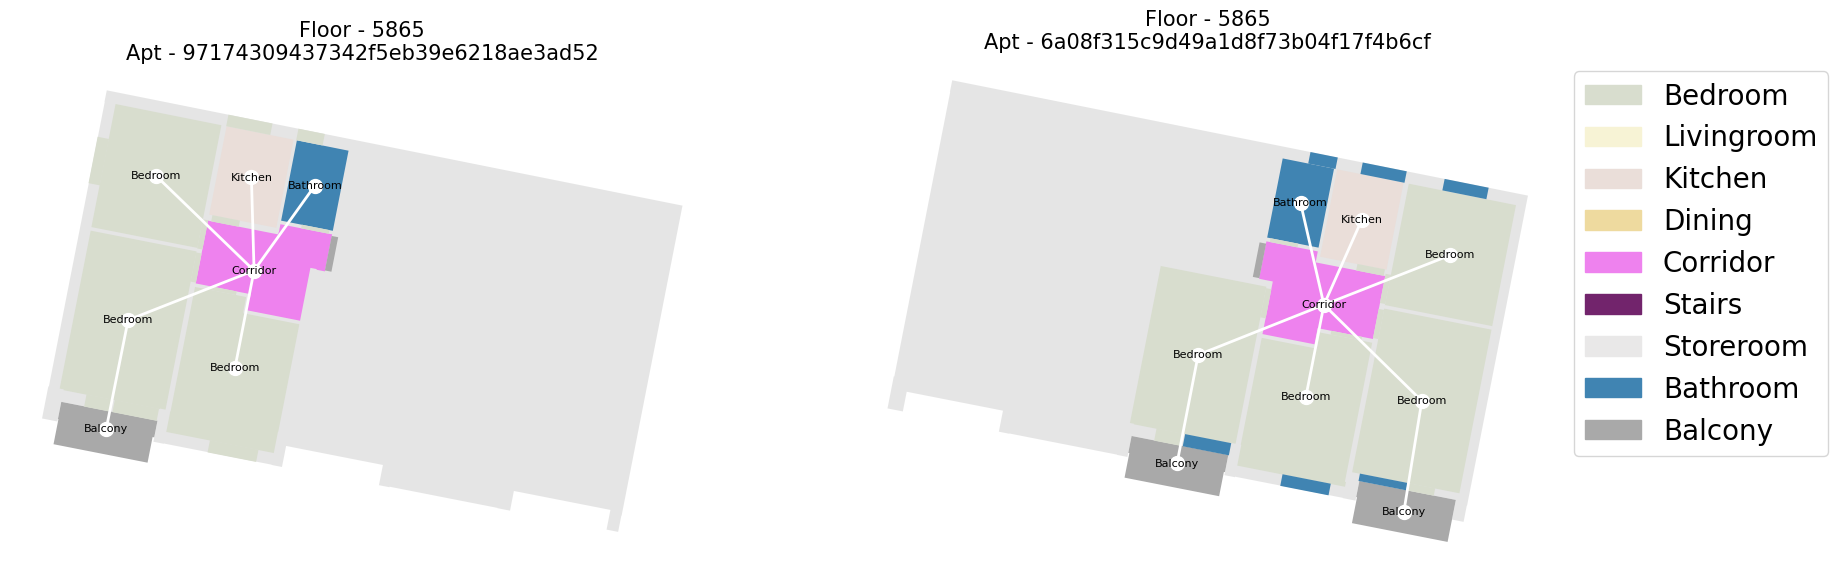

In [ ]:
# Set figure and specs
fs = 10
nc = len(apartments)  # Number of columns
fig, axs = plt.subplots(1, nc, figsize=(fs*nc, fs))
axs = axs.flatten() if nc > 1 else [axs]

# Loop through apartments
for ax, G in zip(axs, graphs):

    # Set axis
    ax.set_aspect('equal')
    ax.axis('off')

    # Plot structure of the whole building
    plot_polygon(ax, slabBoundary, facecolor="gray", alpha=0.2)

    # Plot floor plan + graph on top of it
    draw_floor_from_graph(G, ax, s=fs, w=fs/5,
                          node_color="white",
                          edge_color="white",
                          viz_walls=False)  # Structure not shown. (Remove or set to True if you want to see.)

    # Put title (floor and apt ID)
    ax.set_title(f"Floor - {G.graph['Floor ID']}\nApt - {G.graph['Apt ID']}", fontsize=fs*1.5)

# Create legend (left middle outside)
patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, names)]
patches = [mpatches.Patch(color=color, label=label) for color, label in zip(room_colors, room_names)]
_ = plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1, 1), fontsize=fs*2)

Now, we can loop over all floor and extract the apartment graphs from them.

In [ ]:
# Compute number of apartments
#WARNING NEED TO CHECK FLOOR IDS
print(len(floor_ids))
N_apartments = 0
for floor_id in floor_ids:
    N_apartments += DF[DF.floor_id == floor_id].apartment_id.dropna().nunique()

print(f"Number of apartments:\t{N_apartments}")

4
Number of apartments:	8


It takes quite a while to extract all the graphs.
You can also do it for the first 10 floor plans to check the code, like we do in the following block:

In [ ]:
graphs = []


for floor_id in floor_ids[:50]:

    # Get apartment IDs within the floor
    apartment_ids = list(DF[DF.floor_id == floor_id].apartment_id.dropna().unique())

    # Loop over the apartments and extract the graphs
    for apartment_id in apartment_ids:
        geoms, cats,zonings = get_geometries_from_id(DF, building_id, floor_id, apartment_id=apartment_id)
        G = extract_access_graph(geoms, cats, room_names, apartment_id, floor_id)
        graphs.append(G)

    clear_output(wait=True)
    print(f"Apartments done: {len(graphs)} / {N_apartments}")

Apartments done: 8 / 8


In [ ]:
import pickle

def save_pickle(object, filename):
    """Saves a pickled file."""
    with open(filename, 'wb') as f:
        pickle.dump(object, f)
    f.close()

# Saves graphs
save_pickle(graphs, '/content/drive/MyDrive/MSD_V2/MSD_export/MSD - Some Apartment-Level Graphs.pickle')

Again, we can visualize them (say 20 by 6).

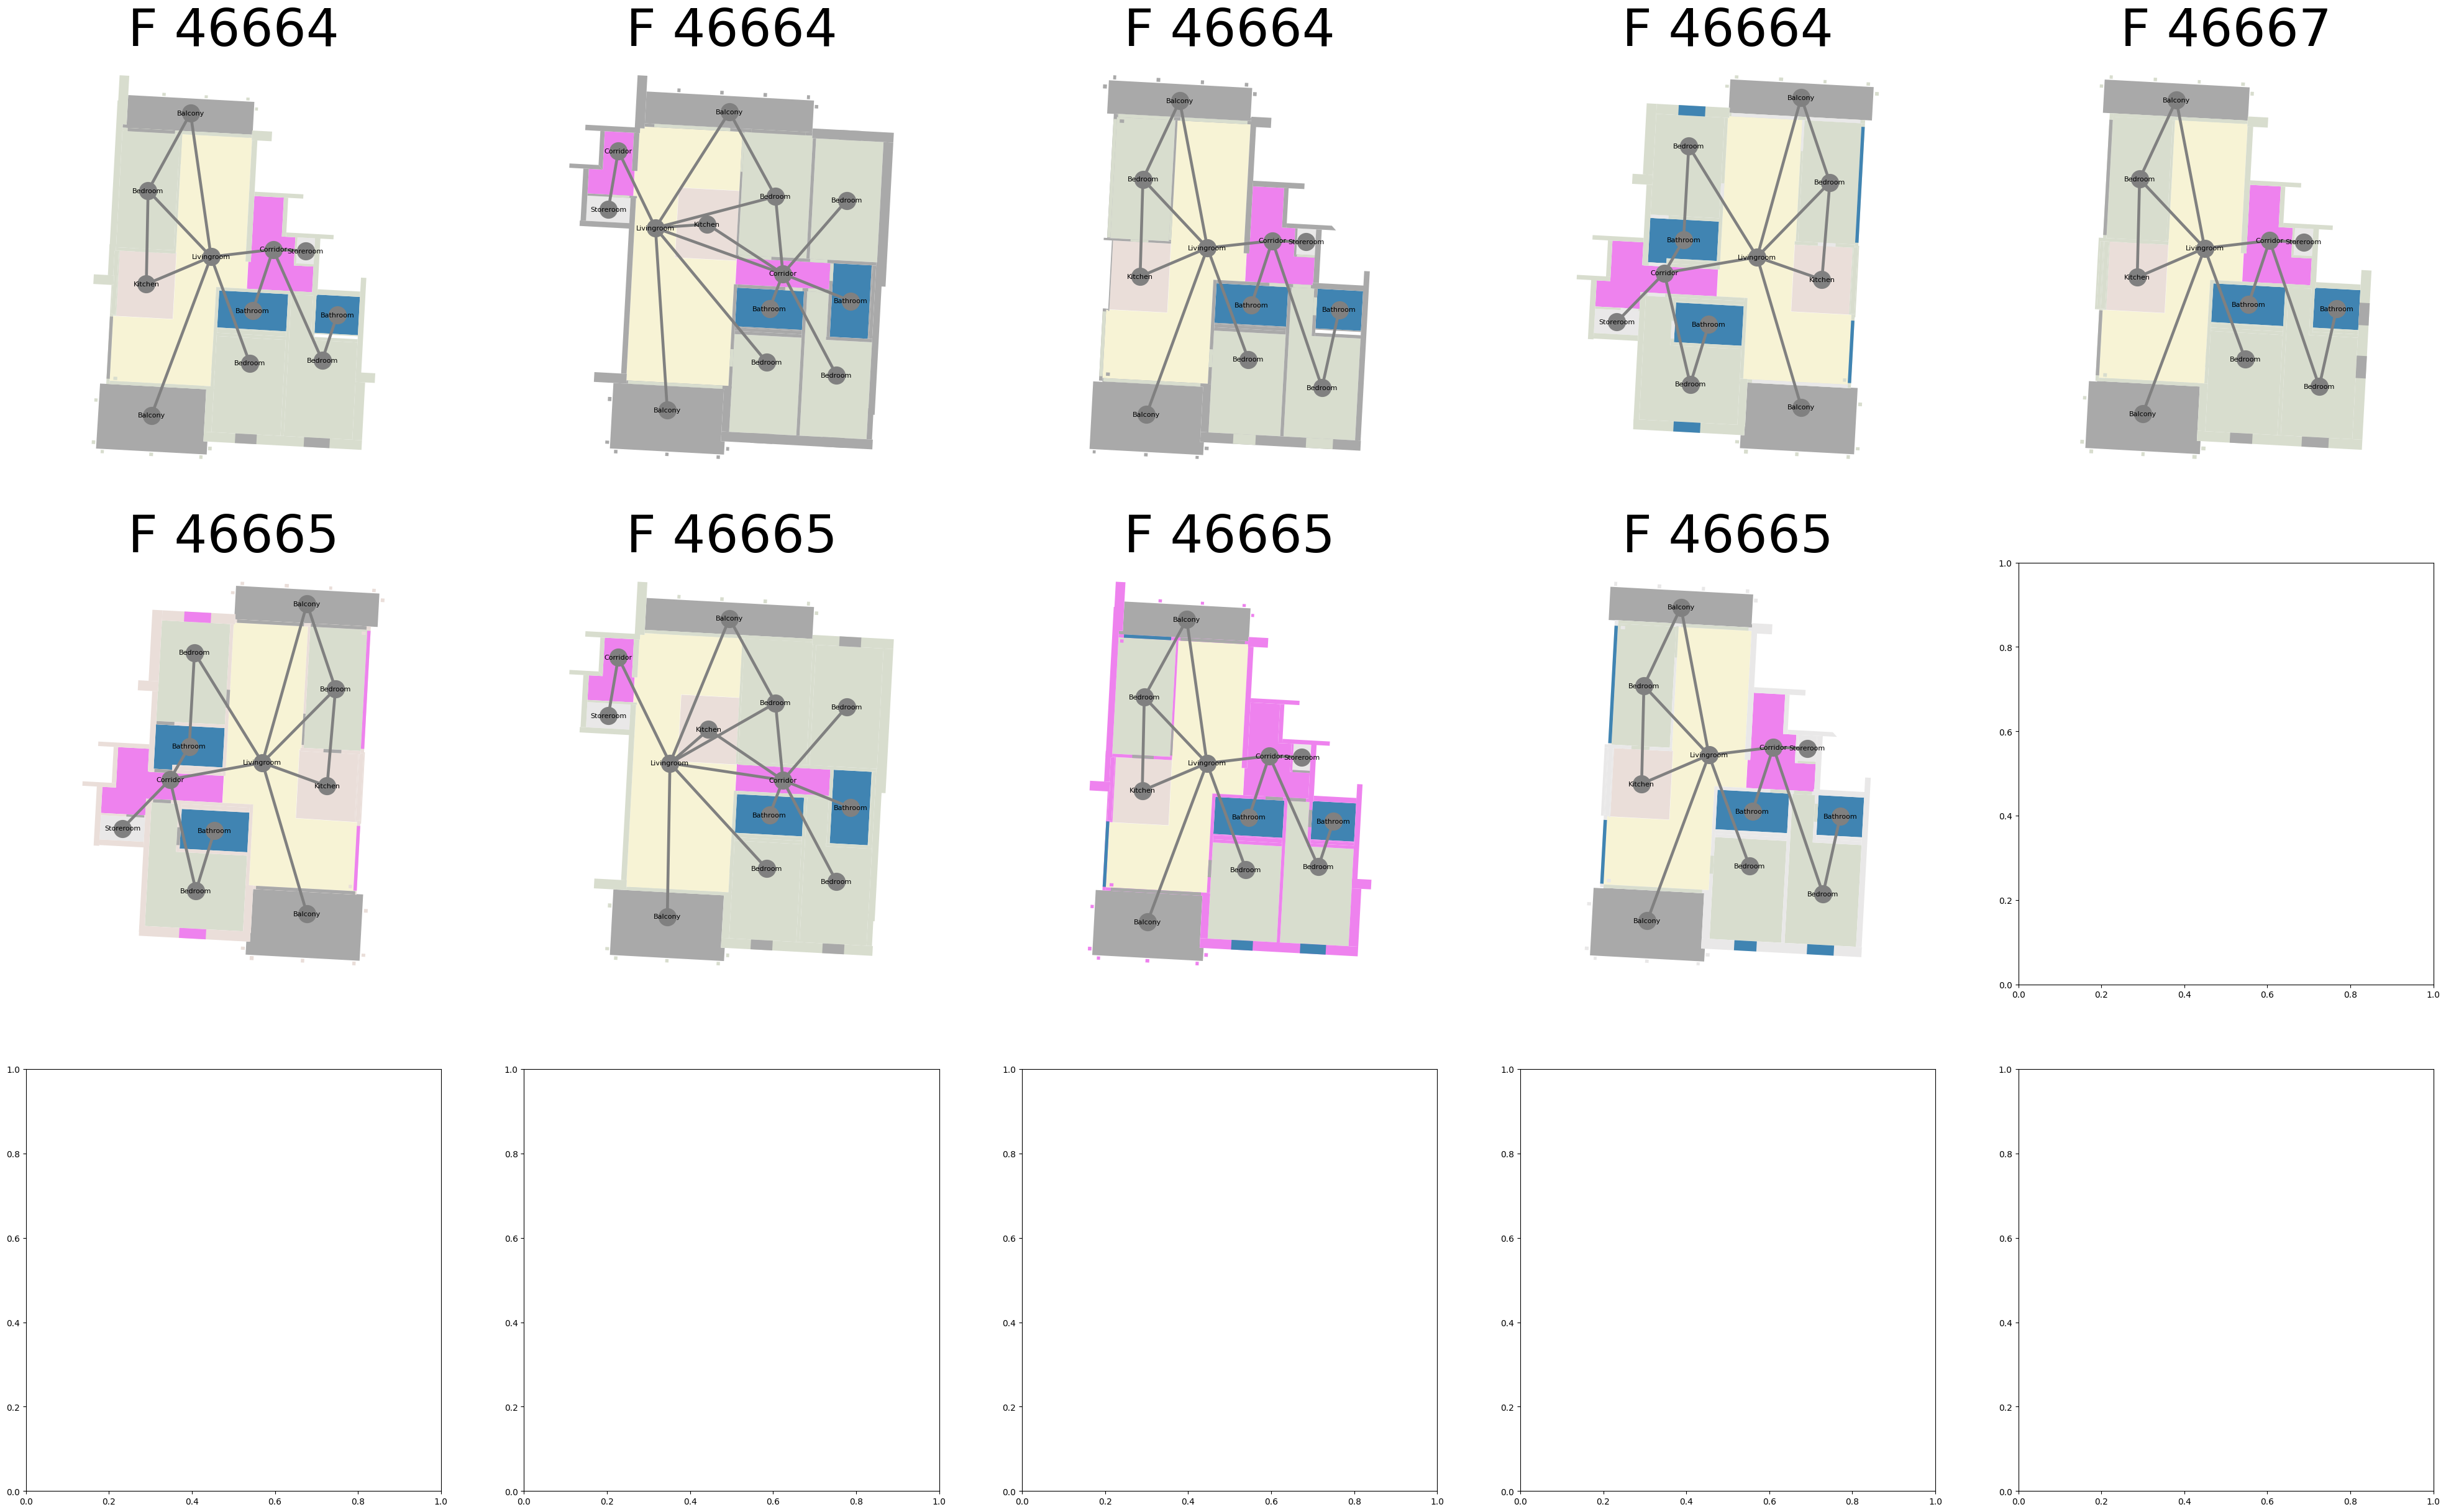

In [ ]:
# Set figure and specs
fs = 10
#nc ->number of Columns,
#nr number of rows
nc, nr = 5, 3
fig, axs = plt.subplots(nr, nc, figsize=(fs*nc, fs*nr))
axs = axs.flatten()

# Set coloring of graph
node_color = edge_color = "grey"

# Loop through apartments
for ax, G in zip(axs, graphs[:len(axs)]):

    # Set axis
    ax.set_aspect('equal')
    ax.axis('off')
    #Put title (floor and apt ID)
    ax.set_title(f"F {G.graph['Floor ID']}", fontsize=fs*6)

    # Plot floor plan + graph
    draw_floor_from_graph(G, ax, s=fs*4, w=fs/3,
                          node_color=node_color,
                          edge_color=edge_color,
                          viz_walls=True,
                          viz_entrances=False)



## (3) Filtering

This section is about removing apartment layouts that are either nearly similar to others (1) are not very informative (e.g., the upper part of an apartment that might only have 1 bedroom) (2).
Why (1)? Too many very similar layouts will slow down and likely bias training.
Why (2)? Good question ...

### Counting storeys in an apartment

Some apartments live at multiple storeys in a building.

Let's plot the histogram of the number of storeys apartments have.
This is easily extracted from the dataframe by counting the number of unique floor IDs can be found when the dataframe is filtered on a particular apartment ID.

In [ ]:
# Get apartment IDs
apartment_ids = list(DF.apartment_id.dropna().unique())
print(len(apartment_ids))

# Get unit IDs (Should be more!)
unit_ids = list(DF.unit_id.dropna().unique())
print(len(unit_ids))

In [ ]:
# Get storeys per apartment dataframe
storeys_per_apartment = DF.groupby('apartment_id')['floor_id'].nunique()

In [ ]:
# Set figure
fs = 7
fig, ax = plt.subplots(1, 1, figsize=(fs, fs))

# Histogram
ax.hist(storeys_per_apartment, bins=range(1, storeys_per_apartment.max() + 2), color='black', align='left', log=True, rwidth=0.9)

# Set labels
ax.set_xlabel('Number of Storeys', fontsize=fs*2)
ax.set_ylabel('Number of Apartments', fontsize=fs*2)
_ = ax.set_title('Storeys per Apartment', fontsize=fs*3)

# Set axes
ax.grid(axis='y', linestyle='--', alpha=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

Since there are only a few apartments covering multiple storeys, we simply don't consider these apartments.

In [ ]:
single_apartment_ids = storeys_per_apartment[storeys_per_apartment == 1].index.tolist()
print("Apartments that only occupy one floor level: ", len(single_apartment_ids))

### Extracting all apartment graphs that are single storey

In the next cell, we will convert all the (single-storey) apartments to information-rich graphs and put them together in a list.
This procedure takes quite some time (~30 min, depending on your machine / server).
Make sure to save it afterwards: Loading the list of graphs from your folder takes way less time than repeating the extraction.

In [ ]:
graphs = []

for floor_id in floor_ids:

    # Get apartment IDs within the floor
    apartment_ids = list(DF[DF.floor_id == floor_id].apartment_id.dropna().unique())
     # Remove those that are covering more than 1 storey (by set intersection)
    apartment_ids = list(set(apartment_ids).intersection(set(single_apartment_ids)))

    # Loop over the apartments and extract the graphs
    for apartment_id in apartment_ids:
        geoms, cats = get_geometries_from_id(DF, floor_id, apartment_id=apartment_id)
        G = extract_access_graph(geoms, cats, names, apartment_id, floor_id)
        graphs.append(G)

    clear_output(wait=True)
    print(f"Apartments done: {len(graphs)} / {len(single_apartment_ids)}")

Again: don't forget to save them.
Note that it's about 150MB only!

In [ ]:
# Saves graphs
save_pickle(graphs, f'/content/drive/My Drive/mds_V2/MSD - Apartment-Level Graphs {len(graphs)/1000:.1f}K.pickle')

Load the graphs

In [ ]:
def load_pickle(filename):
    """
    Loads a pickled file.
    """
    with open(filename, 'rb') as f:
        object = pickle.load(f)
        f.close()
    return object

In [ ]:
graphs = load_pickle('/content/drive/My Drive/mds_V2/MSD_export/MSD - Some Apartment-Level Graphs.pickle')

Let's visualize a couple of them:

In [ ]:
import random

# Set figure and specs
fs = 10
nc, nr = 5, 5
fig, axs = plt.subplots(nr, nc, figsize=(fs*nc, fs*nr))
axs = axs.flatten()

# Set coloring of graph
node_color = edge_color = "black"

# Loop through apartments (pick at random)
random.seed(32)
for ax, G in zip(axs, random.sample(graphs, k=nc*nr)):

    # Set axis
    ax.set_aspect('equal')
    ax.axis('off')

    # Plot floor plan + graph
    draw_floor_from_graph(G, ax, s=fs*4, w=fs/3,
                          node_color=node_color,
                          edge_color=edge_color,
                          viz_walls=False,
                          viz_entrances=False)

    # Put title (floor and apt ID)
    ax.set_title(f"Floor ID: {G.graph['Floor ID']}", fontsize=fs*5)

While many of the floor plans are great, there are many that are not really informative, such as:

- Floor plans that consist of a few number of rooms (some are only bedrooms ...)
- Floor plans without a living room. Reconsidered: We keep them in, there are many apartments without it.

Let's check the sizes (in terms of amount of rooms) of the apartments (1) and number of apartments with a living room more closely (2).

In [ ]:
from tqdm.auto import tqdm

N_rooms = []
N_with_living = 0

for G in tqdm(graphs):
    N_rooms.append(G.number_of_nodes())  # (1)
    # Checks presence of living room among the nodes
    N_with_living += 1 if 1 not in [d for _, d in G.nodes(data="category")] else 0  # (2)

In [ ]:
# Print number of apartments that have a living room
print(N_with_living)
print(N_rooms[:50])

Check distribution of the apartment sizes (i.e., the amount of rooms) through a histogram.

In [ ]:
# Set figure
fs = 7
fig, ax = plt.subplots(1, 1, figsize=(fs, fs))

# Histogram
ax.hist(N_rooms, bins=range(1, np.max(N_rooms) + 2), color='black', align='left', rwidth=0.7)

# Set labels
ax.set_xlabel('Number of Spaces', fontsize=fs*2)
ax.set_ylabel('Number of Apartments', fontsize=fs*2)
_ = ax.set_title('Number of Spaces per Apartment', fontsize=fs*3)

# Set axes
ax.grid(axis='y', linestyle='--', alpha=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

We keep all apartments that have between 5 and 7 rooms.

In [ ]:
graphs_subset = [G for G in tqdm(graphs) if 5 <= G.number_of_nodes() <= 7]

print(f"Number of apartments with 5-12 rooms: {len(graphs_subset)}")

Some apartment are not fully connected.
Here, we keep all apartments that are connected.

In [ ]:
graphs_subset = [G for G in tqdm(graphs_subset) if nx.is_connected(G)]

print(f"Number of apartments with 5-12 rooms and connected: {len(graphs_subset)}")

So, ultimately, in the final dataset we have 16771 apartment-level floor plan graphs.

In [ ]:
import random

# Set figure and specs
fs = 10
#number of rows and columns in the figure
nc, nr = 10, 10
fig, axs = plt.subplots(nr, nc, figsize=(fs*nc, fs*nr))
axs = axs.flatten()

# Set coloring of graph
viz_rooms = True
viz_walls = False
viz_entrances = False
viz_doors = True
viz_windows = True
node_color = edge_color ="black" # other option: fuchsia (pink!)

# Loop through apartments (pick at random)
random.seed(30)
for ax, G in zip(axs, random.sample(graphs_subset, k=nc*nr)):

    # Set axis
    ax.set_aspect('equal')
    ax.axis('off')

    # Plot floor plan + graph
    draw_floor_from_graph(G, ax, s=fs*4, w=fs/3,
                          node_color=node_color,
                          edge_color=edge_color,
                          viz_rooms=viz_rooms,
                          viz_walls=viz_walls,
                          viz_entrances=viz_entrances,
                          viz_doors = viz_doors,
                          viz_windows = viz_windows)

    # Put title (floor and apt ID)
    # ax.set_title(f"F {G.graph['Floor ID']}", fontsize=fs*6)

Let's save this 'cleaned' dataset as well:

In [ ]:
save_pickle(graphs_subset, f'/content/drive/MyDrive/MSD_V2/MSD_export/MSD - Apartment-Level Graphs Cleaned {len(graphs_subset)/1000:.1f}K.pickle')

## (4) Meta-data analysis

This part of the notebook sheds light on the meta-data of the dataset.

We divide it into three categories:

- Numeric
- Semantic
- Geometric
- Topological

### Numeric

First things first.
The next shows the apartment size distribution (as per number of rooms).
We already did this before, but not for the final dataset!

In [ ]:
N_rooms = [G.number_of_nodes() for G in graphs_subset]

N_rooms_dict = {n: N_rooms.count(n) for n in np.sort(list(set(N_rooms)))}

NameError: name 'graphs_subset' is not defined

In [ ]:
# Get naming and occurrences for the bars
names = N_rooms_dict.keys()
occurrences = N_rooms_dict.values()

# Set figure
fs = 7
tc = "black"
fig, ax = plt.subplots(1, 1, figsize=(fs, fs))

# Histogram
bars = ax.bar(names, occurrences, color='black')

# Set labels
ax.set_xlabel('Number of rooms', fontsize=fs*3)
ax.set_ylabel('Amount of apartments', fontsize=fs*3)
ax.tick_params(axis='both', width=fs/3, labelsize=fs*2)

# Set axes / spines
ax.spines['bottom'].set_color(tc)
ax.spines['left'].set_color(tc)
ax.spines['bottom'].set_linewidth(fs/3)
ax.spines['left'].set_linewidth(fs/3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Hide the y-axis ticks and labels
ax.yaxis.set_ticks([])
ax.yaxis.set_ticklabels([])

# Add scores on top of the bars
for bar, occurrence in zip(bars, occurrences):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{occurrence}', ha='center', va='bottom', fontsize=2.5*fs)

### Semantic

We will extract the **room type distribution** i.e., the total number of rooms per room type across the whole dataset.

In [ ]:
# Set classes (int) based on the room names list
classes = list(range(len(room_names)))

# The following creates a list of categories by looping over all the rooms across all graphs
N_room_types = np.concatenate([np.array([cat for _, cat in G.nodes(data="category")]) for G in graphs_subset]).tolist()

# This creates a dictionary: keys are the room types and the values are the number occurrences
# of that room type in the dataset
N_room_type_dict = {room_names[cat]: N_room_types.count(cat) for cat in classes}

# We sort the dictionary by the count of the rooms
N_room_type_dict = dict(sorted(N_room_type_dict.items(), key=lambda item: item[1], reverse=True))

In [ ]:
# Get naming and occurrences for the bars
names = N_room_type_dict.keys()
occurrences = N_room_type_dict.values()

# Set figure
fs = 7
tc = "black"
fig, ax = plt.subplots(1, 1, figsize=(fs*2, fs))

# Histogram
color = [room_colors[room_names.index(cat)] for cat in names]
bars = ax.bar(names, occurrences, color=color)

# Set labels
ax.set_ylabel('Amount', fontsize=fs*3)
ax.tick_params(axis='both', width=fs/3, labelsize=fs*2)

# Set axes / spines
ax.spines['bottom'].set_color(tc)
ax.spines['left'].set_color(tc)
ax.spines['bottom'].set_linewidth(fs/3)
ax.spines['left'].set_linewidth(fs/3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Hide the y-axis ticks and labels
ax.yaxis.set_ticks([])
ax.yaxis.set_ticklabels([])
_ = plt.xticks(rotation=60)

# Add scores on top of the bars
for bar, occurrence in zip(bars, occurrences):
    p = 100 * occurrence / sum(occurrences)  # Computes percentage
    height = bar.get_height()  # Sets the height of the bar in the plot
    ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{occurrence}', ha='center', va='bottom', fontsize=2.5*fs)

### Geometric

We will extract the distributions of the following:
- Gross area (in $m^2$)
- Area per room type (in $m^2$)
- Area of a room type w.r.t. gross area (in %)

The **gross area**, or total area of a floor plan is measured in $m^2$, and computed as the sum over all room areas.

In [ ]:
# Aggregate gross areas in a list
gross_areas = [np.sum([Polygon(d).area for _, d in G.nodes('polygon')]) for G in graphs_subset]

In [ ]:
# Set figure
fs = 7
fc = "white"
tc = "black"
fig, ax = plt.subplots(1,1,figsize=(fs*2, fs))

# Create histogram
bars = ax.hist(gross_areas, bins=75, color="black", align='left', rwidth=1)

# Set color
fig.set_facecolor(fc)
ax.set_facecolor(fc)

# Make up spines
ax.spines['bottom'].set_color(tc)
ax.spines['left'].set_color(tc)
ax.spines['bottom'].set_linewidth(fs/5)
ax.spines['left'].set_linewidth(fs/5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Make up ticks
ax.tick_params(axis='both', width=fs/5, labelsize=fs*2)

# Set grid
ax.grid(axis='y', linestyle='--', alpha=1)

# Make up labels
_ = ax.set_ylabel("Number of floor plans", fontsize=fs*3)
_ = ax.set_xlabel("Gross area [m2]", fontsize=fs*3)

We will do the same, but for each room type individually.
So, we'll get the **distribution of area per room type** (on average across the whole dataset).

In [ ]:
# Aggregate room areas in a dict (key indicates the room type)
room_areas_dict = {cat: [] for cat in room_names}

# Loop over graphs and nodes
for G in graphs_subset:
    for _, d in G.nodes(data=True):
        # Extract category
        cat = room_names[d["category"]]
        # Append to the right list in the dictionary
        room_areas_dict[cat].append(Polygon(d["polygon"]).area)

First, we create bar plot.
Each bar represents a room type.
We compute the mean and standard deviation of the list of areas (values in the dictionary) for each room type category (keys in the dictionary).

In [ ]:
# Create dictionary with statistics of the distribution (mean and std)
S_room_areas_dict = {cat: [np.mean(areas), np.std(areas)] for cat, areas in room_areas_dict.items()}

# Sort dictionary on mean area size (descending order)
S_room_areas_dict = dict(sorted(S_room_areas_dict.items(), key=lambda item: item[1][0], reverse=True))

In [ ]:
# Get naming and occurrences for the bars
names = S_room_areas_dict.keys()
means = [m for m,_ in S_room_areas_dict.values()]
sigmas = [sig for _, sig in S_room_areas_dict.values()]

# Set figure
fs = 7
tc = "black"
fig, ax = plt.subplots(1, 1, figsize=(fs*2, fs))

# Histogram
colors = [room_colors[room_names.index(cat)] for cat in names]
bars = ax.bar(names, means, color=colors)

# Set labels
ax.set_ylabel('Area [m2] ($\mu \pm \sigma$)', fontsize=fs*3)
ax.tick_params(axis='both', width=fs/3, labelsize=fs*2)

# Set axes / spines
ax.spines['bottom'].set_color(tc)
ax.spines['left'].set_color(tc)
ax.spines['bottom'].set_linewidth(fs/3)
ax.spines['left'].set_linewidth(fs/3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Hide the y-axis ticks and labels
ax.yaxis.set_ticks([])
ax.yaxis.set_ticklabels([])
_ = plt.xticks(rotation=60)

# Add scores on top of the bars
for bar, mean, sig in zip(bars, means, sigmas):
    height = bar.get_height()  # Sets the height of the bar in the plot
    ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{mean:.1f}$\pm${sig:.1f}', ha='center', va='bottom', fontsize=2.5*fs)

To investigate more of the details of the individual area distributions, we can similarly visualize the distributions of each of them (using histograms like for the gross area).
We color the the histograms accordingly.

In [ ]:
# Set up figure
fs = 10
fc = "white"
tc = "black"
fig, axs = plt.subplots(2, 5, figsize=(fs*5, fs*2))
axs = axs.flatten()

for ax, cat, color in zip(axs, names, colors):

    # Create histogram
    bars = ax.hist(room_areas_dict[cat], bins=50, color=color)

    # Global coloring
    fig.set_facecolor(fc)
    ax.set_facecolor(fc)

    # Make up spines
    ax.spines['bottom'].set_color(tc)
    ax.spines['left'].set_color(tc)
    ax.spines['bottom'].set_linewidth(fs/3)
    ax.spines['left'].set_linewidth(fs/3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.spines['left'].set_visible(False)

    # Set lim
    # ax.set_xlim([0, 65])

    # Set grid
    ax.grid(axis='y', linestyle='--', alpha=1)

    # Make up ticks
    _ = plt.xticks(rotation=60)
    ax.tick_params(axis='both', width=fs/3, labelsize=fs*4)

    # Set title
    ax.set_title(cat, fontsize=fs*5)

for i in [-1]:
    axs[i].axis("off")

### Topological

Here, we compute the mean (and standard deviation) number connections per room type.

In [ ]:
# Aggregate connections (i.e., degree) areas in a dict (key indicates the room type)
room_degree_dict = {cat: [] for cat in room_names}

# Loop over graphs and nodes
for G in graphs_subset:
    for n, d in G.nodes(data=True):
        # Extract category
        cat = room_names[d["category"]]
        # Append to the correct list in the dictionary
        room_degree_dict[cat].append(G.degree(n))

NameError: name 'graphs_subset' is not defined

In [ ]:
# Create dictionary with statistics of the distribution (mean and std)
S_room_degree_dict = {cat: [np.mean(areas), np.std(areas)] for cat, areas in room_degree_dict.items()}

# Sort dictionary on mean area size (descending order)
S_room_degree_dict = dict(sorted(S_room_degree_dict.items(), key=lambda item: item[1][0], reverse=True))

In [ ]:
# Get naming and occurrences for the bars
names = S_room_degree_dict.keys()
means = [m for m,_ in S_room_degree_dict.values()]
sigmas = [sig for _, sig in S_room_degree_dict.values()]

# Set figure
fs = 7
tc = "black"
fig, ax = plt.subplots(1, 1, figsize=(fs*2, fs))

# Histogram
colors = [room_colors[room_names.index(cat)] for cat in names]
bars = ax.bar(names, means, color=colors)

# Set labels
ax.set_ylabel('Degree [-] ($\mu \pm \sigma$)', fontsize=fs*3)
ax.tick_params(axis='both', width=fs/3, labelsize=fs*2)

# Set axes / spines
ax.spines['bottom'].set_color(tc)
ax.spines['left'].set_color(tc)
ax.spines['bottom'].set_linewidth(fs/3)
ax.spines['left'].set_linewidth(fs/3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Hide the y-axis ticks and labels
ax.yaxis.set_ticks([])
ax.yaxis.set_ticklabels([])
_ = plt.xticks(rotation=60)

# Add scores on top of the bars
for bar, mean, sig in zip(bars, means, sigmas):
    height = bar.get_height()  # Sets the height of the bar in the plot
    ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{mean:.1f}$\pm${sig:.1f}', ha='center', va='bottom', fontsize=2.5*fs)